In [ ]:
# NOTE: There is a typo with the rendered code blocks for shapiro-wilk test
# where it says failed to reject null hypothesis instead of rejected null hypothesis.

In [ ]:
# COLAB ONLY:
# Import project from google drive
from google.colab import drive 
drive.mount("/content/drive", force_remount=True)
# Change current directory to project dir
import os
os.chdir("drive/My Drive/DLM")

Mounted at /content/drive


In [ ]:
# COLAB ONLY : Install required packages
from importlib.util import find_spec
#if find_spec('pydlm') is None:
os.chdir("./pydlm")
!sudo python setup.py install
os.chdir("..")
if find_spec('pmdarima') is None:  
  !pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot as plot
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason, modelTuner
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.graphics.gofplots import qqplot
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from scipy.stats import shapiro
from math import sqrt
from tqdm import tqdm
import warnings
import statsmodels
import pmdarima
import pickle

In [ ]:
# Clean data, make a date-time index
def get_df(csvfile: str, param: str):
    df = pd.read_csv(csvfile)
    if param == "GHI" or param == "Wind Speed":
        sort_cols = ["Year", "Month", "Day", "Hour"]
        df.sort_values(by=sort_cols, inplace=True)
        if param == "GHI":
          df = df[(df["Hour"] > 7) & (df["Hour"] < 17)]
          df = df[["Year", "Month", "Day", "Hour", "GHI", "Clearsky GHI"]]
        else:
          df = df[["Year", "Month", "Day", "Hour", "Wind Speed"]]
        df["datetime"] = (
            df["Year"].astype(str)
            + "-"
            + df["Month"].astype(str).str.zfill(2)
            + "-"
            + df["Day"].astype(str).str.zfill(2)
            + " "
            + df["Hour"].astype(str).str.zfill(2)
            + ":00:00"
        )
    else:
        sort_cols = ["Year", "Month", "Day"]
        df.sort_values(by=sort_cols, inplace=True)
        df = df[["Year", "Month", "Day", "Wind Speed 50", "Wind Speed 10"]]
        df["datetime"] = (
            df["Year"].astype(str)
            + "-"
            + df["Month"].astype(str).str.zfill(2)
            + "-"
            + df["Day"].astype(str).str.zfill(2)
        )

    df["datetime"] = pd.to_datetime(df["datetime"])
    return df

In [ ]:
def adf_test(df):
    adf = adfuller(df.values)
    print("------------------------------")
    print("ADF Statistic : " + adf[0].astype(str))
    print("p-value :", end=" ")
    print(adf[1])
    crit_val = adf[4]["5%"]
    if (adf[1] < 0.05) and (adf[0] < crit_val):
        print("The series is stationary")
    else:
        print("The series is NOT stationary")
    print("------------------------------")

In [ ]:
# Split the data into 80-20
def split_data(df, type, dtype):
    regressor = df.head(int(len(df) - 1))
    df = df.tail(int(len(df) - 1))
      
    if type == "Monthly":
        rnow = df.index.get_loc('2018-01-31')
    elif type == "Weekly":
        rnow = df.index.get_loc('2018-01-07')
    elif type == "Daily":
        rnow = df.index.get_loc('2019-01-01')
    
    train = df.head(rnow)
    test = df.tail(int(len(df) - rnow))
    test = test.head(int(len(test) - 1))
    idx = test.index
    
    # Convert to numpy arrays (for pyDLM)
    df = np.asarray(df, dtype=float)
    train = np.asarray(train, dtype=float)
    test = np.asarray(test, dtype=float)
    regressor = np.asarray(regressor, dtype=float)
    assert regressor[1] == df[0], "Error: Regressor values aren't one day lag of data"
    return train, test, regressor, df, idx

In [ ]:
def grid_search(train, test, lim, type):
  e_min = 1000 
  p_opt, q_opt, d_opt = -1, -1, -1
  print("ARIMA Limits: ({}, {}, {})".format(lim[0], lim[1], lim[2]))
  for p in tqdm(range(lim[0])):
    for d in range(lim[1]):
      for q in range(lim[2]):
        if p == 0 and q == 0 and d == 0:
          continue
        try: 
          model = statsmodels.tsa.arima.model.ARIMA(train, order = (p,d,q))
          model_fit = model.fit()
          yhat = model_fit.predict(start = p+q+d, end = p+q+d+len(test)-1, dynamic = False)
          e = sqrt(mean_squared_error(yhat, test))
          #print("Params : ({}, {}, {}), Error: {}".format(p, d, q, e))
          if(e_min > e):
            e_min = e
            p_opt = p
            q_opt = q
            d_opt = d
        except:
          pass
  print("------------------------------")
  print("Min Error = {} ; Best Params = ({}, {}, {})".format(e_min, p_opt, d_opt, q_opt))
  print("------------------------------")
  return (p_opt, d_opt, q_opt)

In [ ]:
# Bhadla ARIMA Params:
# 1. Daily: 2, 1, 1
# 2. Weekly: 1, 0, 1
# 3. Monthly: 1, 0, 0
# Bhadla Auto SARIMA:
# 1. Monthly: 0, 0, 2 Seas: 1, 0, 2, 12
# 2. Weekly: 1, 0, 1 Seas: 0, 0, 3, 52
def sarima_model(train, test, param, type, stype, idx):
    warnings.filterwarnings("ignore")
    test_len = len(test)
    if stype == "SARIMA":
        if type == "Daily": slen = 365
        elif type == "Weekly": slen = 52
        elif type == "Monthly": slen = 12

        #sarimaModel = pmdarima.arima.auto_arima(train, start_p=0, start_q=0, max_p=2,max_q=2, start_P=0, 
        #                                        start_Q=0, max_P=2, max_Q=2, m=slen, n_fits=25,
        #                                        max_order=None, trace=True, random=True, seasonal = True,
        #                                        with_intercept=False, stationary = True, stepwise = False)
        #sarimaModel = pmdarima.arima.ARIMA(order = sarimaModel.order, seasonal_order = sarimaModel.seasonal_order)
        if type == "Monthly": sarimaModel = pmdarima.arima.ARIMA(order = (1, 0, 0), seasonal_order = (1, 0, 2, 12))
        elif type == "Weekly": sarimaModel = pmdarima.arima.ARIMA(order = (1, 0, 1), seasonal_order = (1, 0, 2, 52))
        else: sarimaModel = pmdarima.arima.ARIMA(order = (1, 0, 0), seasonal_order = (1, 0, 2, 355))

        sarimaModel = sarimaModel.fit(train)
        # print(sarimaModel.summary())
        sarimaPred = sarimaModel.predict(n_periods = test_len)
        
    elif stype == "ARIMA":
        if type == "Daily":
            lim = (5, 3, 5)
            slen = 365
        elif type == "Weekly" or type == "Monthly":
            lim = (5, 3, 5)
            if type == "Weekly": slen = 52
            elif type == "Monthly": slen = 12

        opt_ord = grid_search(train, test, lim, type)
        sarimaModel = statsmodels.tsa.arima.model.ARIMA(train, order=opt_ord)
        sarimaModel = sarimaModel.fit()
        sarimaPred = sarimaModel.predict(start = sum(opt_ord), end = sum(opt_ord)+test_len-1, dynamic = False)
        

    sarimaPred = pd.DataFrame(sarimaPred, index = idx, columns = [stype])
    sarimaRes = np.subtract(test, sarimaPred)
    sarimaRes = np.asarray(sarimaRes, dtype=float)
    sarimaResMean = sum(list(filter(lambda x: (x), sarimaRes))) / len(test)
    sErr = []
    sErr.append(sqrt(mean_squared_error(sarimaPred, test)))
    sErr.append(mean_absolute_error(sarimaPred, test))
    sErr.append(mean_absolute_percentage_error(sarimaPred, test))
    sarimaRes = pd.DataFrame(sarimaRes, index = idx, columns = [stype + ' Res'])

    return sarimaPred, sErr, sarimaRes, sarimaResMean

In [ ]:
# Create the dlm
def create_dlm(regressor, df, mtype, type):
    prd = 365
    if type == "Weekly":
        prd = 52
    elif type == "Monthly":
        prd = 12

    if(mtype == "Regressive"):
        dyn = dynamic(features=regressor[:len(df)], discount=0.99999, name="dyn", w=10)
        seas = seasonality(period=prd, name="Season", discount=0.99999, w=10)
        tr = trend(degree=1, discount=0.99999, name='linear_trend', w=10)
        dlmModel = dlm(df) + dyn + seas + tr
    elif(mtype == "Trend"): # Trend only model gives constant value
        dlmModel = dlm(df) + trend(2, name='lineTrend', w=10.0)
    elif(mtype == "Seasonal"):
            seas = seasonality(period=prd, name="Season", discount=0.99999, w=10)
            tr = trend(degree=1, discount=0.99999, name='linear_trend', w=10)
            dlmModel = dlm(df) + seas + tr

    if type != "Daily":
      dlmTuner = modelTuner(method = 'gradient_descent', loss = 'mse')
      print("Tuning model...")
      dlmModel = dlmTuner.tune(dlmModel, maxit = 20)
      print("Tuning finished.")
      print("Tuned d: {}".format(dlmTuner.getDiscounts()))

    dlmModel.fitForwardFilter()
    
    if mtype == "Regressive":
      dynMean = dlmModel.getMean(name='dyn')
    else:
      # to return dummy value
      dynMean = dlmModel.getMean(name='Season')
   
    return dlmModel, dlmModel.getMean(name='linear_trend'), dlmModel.getMean(name='Season'), dynMean

In [ ]:
def plotDLMComp(tr, seas, dyn, mtype):
    if mtype == "Regressive":
        fig, axs = plt.subplots(3, 1)
        fig.suptitle('Regressive DLM Components')
        axs[2].plot(dyn)
        axs[2].set_ylabel('Regressive', fontsize=10)
        axs[2].get_yaxis().set_label_coords(-0.1,0.5)
    else:
        fig, axs = plt.subplots(2, 1)
        fig.suptitle('Seasonal DLM Components')
    axs[0].plot(tr)
    axs[0].set_ylabel('Trend', fontsize=10)
    axs[0].get_yaxis().set_label_coords(-0.1,0.5)
    axs[1].plot(seas)
    axs[1].set_ylabel('Seasonal', fontsize=10)
    axs[1].get_yaxis().set_label_coords(-0.1,0.5)

    plt.show()

In [ ]:
# Make predictions given the dlm (Plot predictions and residuals)
def predict(dlmModel, test, train, regressor):
    #dlmModel.turnOff('CI')
    #plt.figure(figsize = (13,5), dpi = 100)
    #dlmModel.plotPredictN(N=len(test), date=len(train)-1)
    (predictMean, predictVar) = dlmModel.predictN(N=len(test), date=len(train)-1)
    

    # MSE and Residuals
    residual = test.reshape(1, len(test)) - predictMean
    residual = np.asarray(residual, dtype=float)
    resMean = np.sum(residual) / len(test)
    residual = residual.reshape(len(test), 1)
    dlmErr = []
    dlmErr.append(sqrt(mean_squared_error(predictMean, test)))
    dlmErr.append(mean_absolute_error(predictMean, test))
    dlmErr.append(mean_absolute_percentage_error(predictMean, test))
    
    return predictMean, residual, resMean, dlmErr

In [ ]:
def res_plot(RegdlmRes, SeasdlmRes, sarimaRes, arimaRes, type):
    # Regressive
    plt.figure(figsize = (13,5), dpi = 100)
    plt.plot(RegdlmRes, label="Regressive", linestyle=':')
    plt.plot(SeasdlmRes, label="Seasonal", linestyle=':')
    if type != "Daily": 
      plt.plot(sarimaRes, label="SARIMA", linestyle=':')
    plt.plot(arimaRes, label="ARIMA", linestyle=':')
    plt.legend()
    plt.grid(visible=True, color='0.95')
    plt.title("Residuals", fontweight = 'bold')
    plt.show()
    
    # Histogram Plot
    if type != "Daily":
      RES = pd.DataFrame(list(zip(RegdlmRes["DLM Res"], SeasdlmRes["DLM Res"], sarimaRes["SARIMA Res"], arimaRes["ARIMA Res"])), columns = ['Regressive', 'Seasonal', 'SARIMA', 'ARIMA'])
    else:
      RES = pd.DataFrame(list(zip(RegdlmRes["DLM Res"], SeasdlmRes["DLM Res"], arimaRes["ARIMA Res"])), columns = ['Regressive', 'Seasonal', 'ARIMA'])
    RES.plot.kde()

    # Shapiro Wilk Test
    def shapiroChk(pval):
      if pval < 0.05:
        print("     Null hypothesis rejected, residuals do not follow normal distribution")

    print("---------SHAPIRO WILK-----------")
    print("Regressive: {}".format(shapiro(RegdlmRes["DLM Res"])))
    shapiroChk(shapiro(RegdlmRes["DLM Res"]).pvalue)
    print("Seasonal: {}".format(shapiro(SeasdlmRes["DLM Res"])))
    shapiroChk(shapiro(SeasdlmRes["DLM Res"]).pvalue)
    if type != "Daily":
      print("SARIMA: {}".format(shapiro(sarimaRes["SARIMA Res"])))
      shapiroChk(shapiro(sarimaRes["SARIMA Res"]).pvalue)
    print("ARIMA: {}".format(shapiro(arimaRes["ARIMA Res"])))
    shapiroChk(shapiro(arimaRes["ARIMA Res"]).pvalue)
    print("------------------------------")
    
    # QQ Plot
    if type != "Daily":
      fig, axs = plt.subplots(2, 2)
      qqplot(RegdlmRes["DLM Res"], line='r', ax=axs[0,0])
      axs[0,0].set_title("Regressive")
      qqplot(SeasdlmRes["DLM Res"], line='r', ax=axs[0,1])
      axs[0,1].set_title("Seasonal")
      qqplot(sarimaRes["SARIMA Res"], line='r', ax=axs[1,0])
      axs[1,0].set_title("SARIMA")
      qqplot(arimaRes["ARIMA Res"], line='r', ax=axs[1,1])
      axs[1,1].set_title("ARIMA")
      for ax in axs.flat: ax.label_outer()
      plt.show()
    else:
      fig, axs = plt.subplots(1, 3, figsize=(12, 4))
      qqplot(RegdlmRes["DLM Res"], line='r', ax=axs[0])
      axs[0].set_title("Regressive")
      qqplot(SeasdlmRes["DLM Res"], line='r', ax=axs[1])
      axs[1].set_title("Seasonal")
      qqplot(sarimaRes["ARIMA Res"], line='r', ax=axs[2])
      axs[2].set_title("ARIMA")
      for ax in axs.flat: ax.label_outer()
      plt.show()

In [ ]:
def pred_plot(test, RegdlmMean, SeasdlmMean, sarimaPred, arimaPred, param, type):
    if type != 'Daily':
      fig, axs = plt.subplots(4,1, figsize=(15, 10))
      axs[3].plot(sarimaPred, label="SARIMA", color='#2ca02c')
      axs[3].plot(test, label="Actual", color='k',linestyle='-.', linewidth=1.4)
      axs[3].set_ylabel('SARIMA', fontsize = 10)
    else: 
      fig, axs = plt.subplots(3,1, figsize=(10, 10))
    fig.suptitle('Predictions', fontweight = 'bold')
    axs[0].plot(RegdlmMean, label="Regressive", color='#1f77b4')
    axs[0].plot(test, label="Actual", color='k',linestyle='-.', linewidth=1.4)
    axs[0].set_ylabel('Regressive', fontsize = 10)
    axs[1].plot(SeasdlmMean, label="Seasonal", color='#ff7f0e')
    axs[1].plot(test, label="Actual", color='k',linestyle='-.', linewidth=1.4)
    axs[1].set_ylabel('Seasonal', fontsize = 10)
    axs[2].plot(arimaPred, label="ARIMA", color='#d62728')
    axs[2].plot(test, label="Actual", color='k',linestyle='-.', linewidth=1.4)
    axs[2].set_ylabel('ARIMA', fontsize = 10)

    for ax in axs.flat: ax.label_outer()
    ax.tick_params('x', labelrotation = 45)
    plt.show()

In [ ]:
def openModel(val, file, type):
    fname = "./output/" + val + "_" + type + "_" + file[:-4].partition(' ')[0] + ".pkl"
    if os.path.isfile(fname):
        return pd.read_pickle(fname)
    else:
        return pd.DataFrame()

In [ ]:
def openList(val, file, type):
    fname = "./output/" + val + "_" + type + "_" + file[:-4].partition(' ')[0] + ".pkl"
    if os.path.isfile(fname):
        with open(fname, "rb") as fp:
            x = pickle.load(fp)
        fp.close()
        return x
    else:
        return []

In [ ]:
def saveList(val, file, type, list):
    fname = "./output/" + val + "_" + type + "_" + file[:-4].partition(' ')[0] + ".pkl"
    # if not os.path.isfile(fname):
    with open(fname, "wb") as fp:
        pickle.dump(list, fp)

In [ ]:
def saveModel(val, file, type, df):
    fname = "./output/" + val + "_" + type + "_" + file[:-4].partition(' ')[0] + ".pkl"
    df.to_pickle(fname)

In [ ]:
# ------------------------------------
# --------- Main function ------------
# ------------------------------------

def main_function(file, param, type):
    df = get_df(file, param)
    df = df[["datetime", param]]
    df.set_index("datetime", inplace=True)

    # Resampling data
    if type != "None":
        df = df.reset_index()
        if type == "Daily":
            if file == "tiruvanantpuram.csv" or file == "Bhadla new.csv":
              df = df.tail(int(len(df) * 0.6))
            df = df.resample("D", on="datetime").mean()
        elif type == "Weekly":
            df = df.resample("W", on="datetime").mean()
        elif type == "Monthly":
            df = df.resample("M", on="datetime").mean()

    print(df.head(n=12))
    # ADF Test and TS Decomposition
    adf_test(df)
    decomp = seasonal_decompose(df, model="additive")
    decomp.plot()
    plt.show()

    (train, test, regressor, df, idx) = split_data(df, type, param)

    # Reg DLM
    print("--------------REGRESSIVE DLM---------------")
    # Check if data exists, use that otherwise create and save for later
    RegdlmMean = openModel("RegdlmMean", file, type)
    RegdlmRes = openModel("RegdlmRes", file, type)
    RegdlmErr = openList("RegdlmErr", file, type)
    tr = openList("Regtr", file, type)
    dyn = openList("Regdyn", file, type)
    seas = openList("Regseas", file, type)
    if RegdlmMean.empty or RegdlmRes.empty or (not RegdlmErr) or (not tr) or (not dyn) or (not seas):
      (RegdlmModel, tr, seas, dyn) = create_dlm(regressor, df, "Regressive", type)
      (RegdlmMean, RegdlmRes, RegdlmResMean, RegdlmErr) = predict(RegdlmModel, test, train, regressor)
      RegdlmMean = pd.DataFrame(RegdlmMean, index = idx, columns = ['DLM'])
      RegdlmRes = pd.DataFrame(RegdlmRes, index = idx, columns = ['DLM Res'])
      saveModel("RegdlmMean", file, type, RegdlmMean)
      saveModel("RegdlmRes", file, type, RegdlmRes)
      saveList("RegdlmErr", file, type, RegdlmErr)
      saveList("Regtr", file, type, tr)
      saveList("Regdyn", file, type, dyn)
      saveList("Regseas", file, type, seas)

    plotDLMComp(tr, seas, dyn, "Regressive")

    #import sys
    #sys.exit()
    # Seas DLM
    print("--------------SEASONAL DLM---------------")
    # Check if data exists, use that otherwise create and save for later
    SeasdlmMean = openModel("SeasdlmMean", file, type)
    SeasdlmRes = openModel("SeasdlmRes", file, type)
    SeasdlmErr = openList("SeasdlmErr", file, type)
    tr = openList("Seastr", file, type)
    dyn = openList("Seasdyn", file, type)
    seas = openList("Seasseas", file, type)
    if SeasdlmMean.empty or SeasdlmRes.empty or (not SeasdlmErr) or (not tr) or (not dyn) or (not seas):
      (SeasdlmModel, tr, seas, dyn) = create_dlm(regressor, train, "Seasonal", type)
      (SeasdlmMean, SeasdlmRes, SeasdlmResMean, SeasdlmErr) = predict(SeasdlmModel, test, train, regressor)
      SeasdlmMean = pd.DataFrame(SeasdlmMean, index = idx, columns = ['DLM'])
      SeasdlmRes = pd.DataFrame(SeasdlmRes, index = idx, columns = ['DLM Res'])
      saveModel("SeasdlmMean", file, type, SeasdlmMean)
      saveModel("SeasdlmRes", file, type, SeasdlmRes)
      saveList("SeasdlmErr", file, type, SeasdlmErr)
      saveList("Seastr", file, type, tr)
      saveList("Seasdyn", file, type, dyn)
      saveList("Seasseas", file, type, seas)

    plotDLMComp(tr, seas, dyn, "Seasonal")
    
    # SARIMA & ARIMA
    (arimaPred, aErr, arimaRes, arimaResMean) = sarima_model(train, test, param, type, "ARIMA", idx)
    if type == "Daily":
        (sarimaPred, sErr, sarimaRes, sarimaResMean) = (arimaPred, aErr, arimaRes, arimaResMean)
    else:
        # Check if data exists, use that otherwise create and save for later
        sarimaPred = openModel("sarimaPred", file, type)
        sarimaRes = openModel("sarimaRes", file, type)
        sErr = openList("sErr", file, type)
        if sarimaPred.empty or sarimaRes.empty or (not sErr):
          (sarimaPred, sErr, sarimaRes, sarimaResMean) = sarima_model(train, test, param, type, "SARIMA", idx)
          saveModel("sarimaPred", file, type, sarimaPred)
          saveModel("sarimaRes", file, type, sarimaRes)
          saveList("sErr", file, type, sErr)
          
    print("--------------SARIMA OVER---------------")
    
    # Plot predictions on test data
    test = pd.DataFrame(test, index = idx, columns = ['Actual'])
    pred_plot(test, RegdlmMean, SeasdlmMean, sarimaPred, arimaPred, param, type)
    errors = ["RMSE", "MAE", "MAPE"]
    Err = pd.DataFrame(list(zip(errors, RegdlmErr, SeasdlmErr, sErr, aErr)), columns = ['Errors', 'Reg', 'Seas', 'SARIMA', 'ARIMA']).transpose()
    print(Err)
    
    # Plot residuals
    res_plot(RegdlmRes, SeasdlmRes, sarimaRes, arimaRes, type)

In [ ]:
# ------------------------------------
# -------- Various options -----------
# ------------------------------------
file = ["tiruvanantpuram.csv", "Bhadla new.csv", "Bhopal.csv", "hamirpur.csv", "jafrabad.csv", "tiruvanantpuram_new.csv"] # 0-5
param = ["Wind Speed 50", "Wind Speed 10", "GHI", "Clearsky GHI", "Wind Speed"]
type = ["None", "Daily", "Weekly", "Monthly"]
mtype = ["Regressive", "Seasonal"]

Bhadla GHI Monthly Predictions
                   GHI
datetime              
2001-01-31  490.875986
2001-02-28  552.553413
2001-03-31  666.180789
2001-04-30  716.345815
2001-05-31  733.664301
2001-06-30  663.971000
2001-07-31  608.245341
2001-08-31  648.745054
2001-09-30  649.872148
2001-10-31  571.413082
2001-11-30  503.221111
2001-12-31  430.965699
------------------------------
ADF Statistic : -5.125199877123293
p-value : 1.2472293409766391e-05
The series is stationary
------------------------------


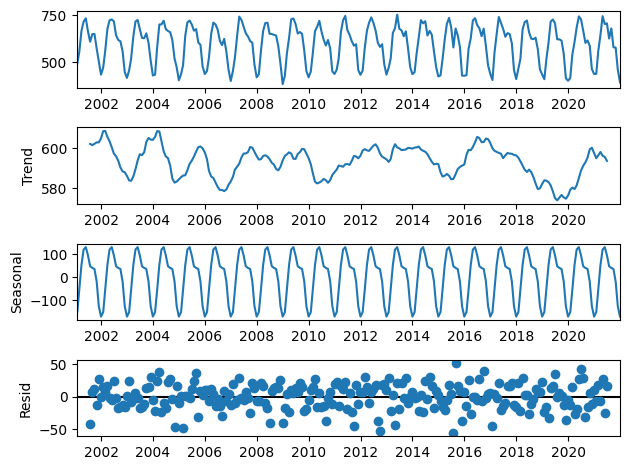

--------------REGRESSIVE DLM---------------


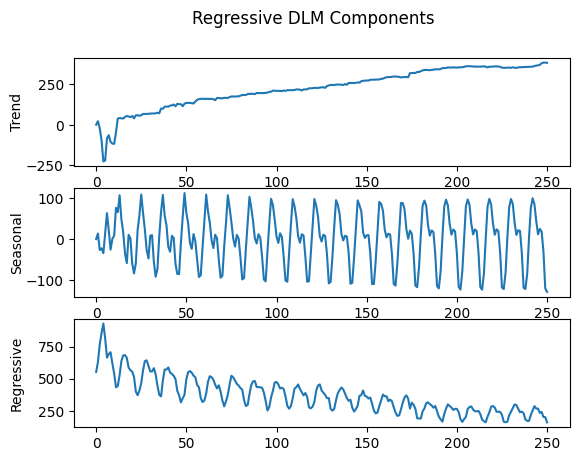

--------------SEASONAL DLM---------------


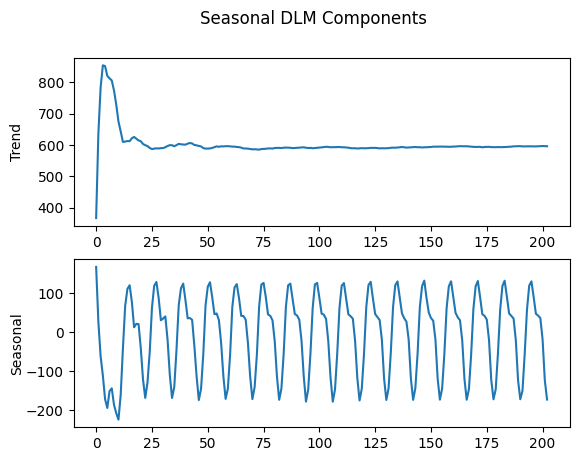

ARIMA Limits: (5, 3, 5)


100%|██████████| 5/5 [00:30<00:00,  6.06s/it]


------------------------------
Min Error = 71.3907910190438 ; Best Params = (1, 0, 0)
------------------------------
--------------SARIMA OVER---------------


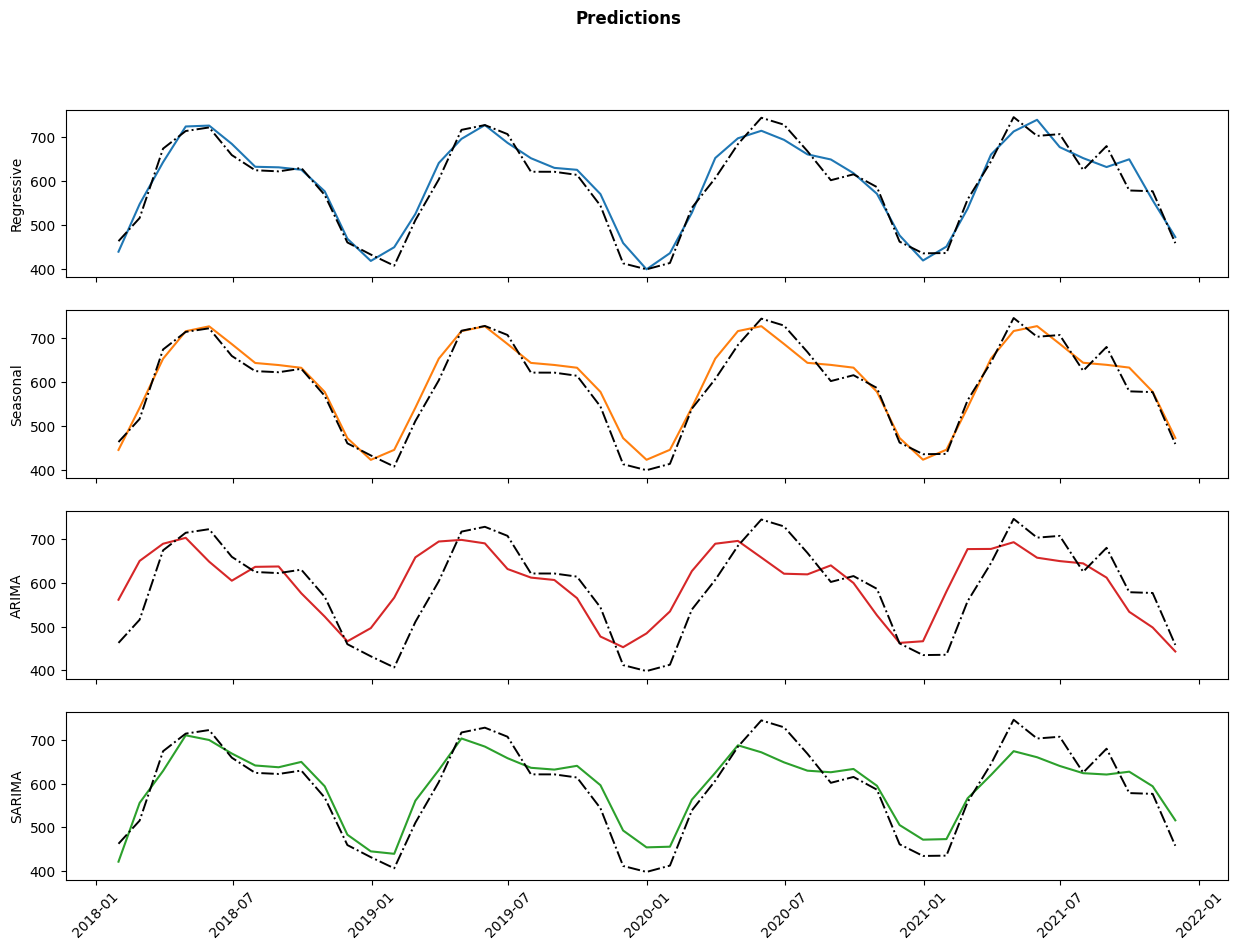

                0          1         2
Errors       RMSE        MAE      MAPE
Reg     26.447635  21.870702  0.037205
Seas    25.672046  21.247598  0.036484
SARIMA  39.635026  33.709762  0.058677
ARIMA   71.390791  58.500129  0.098753


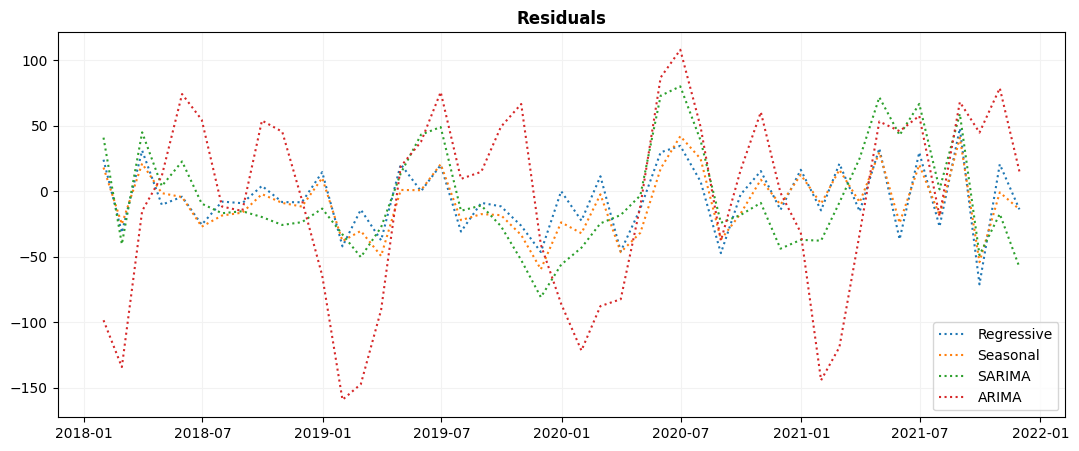

---------SHAPIRO WILK-----------
Regressive: ShapiroResult(statistic=0.9822638630867004, pvalue=0.687442421913147)
Seasonal: ShapiroResult(statistic=0.986374020576477, pvalue=0.8528598546981812)
SARIMA: ShapiroResult(statistic=0.939093291759491, pvalue=0.016467180103063583)
     Fail to reject null hypothesis, residuals do not follow normal distribution
ARIMA: ShapiroResult(statistic=0.9358029961585999, pvalue=0.012394428253173828)
     Fail to reject null hypothesis, residuals do not follow normal distribution
------------------------------


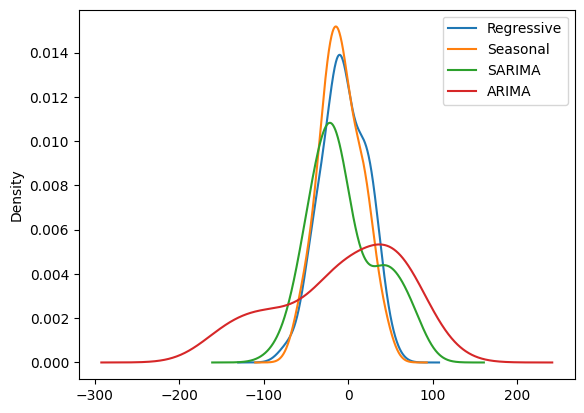

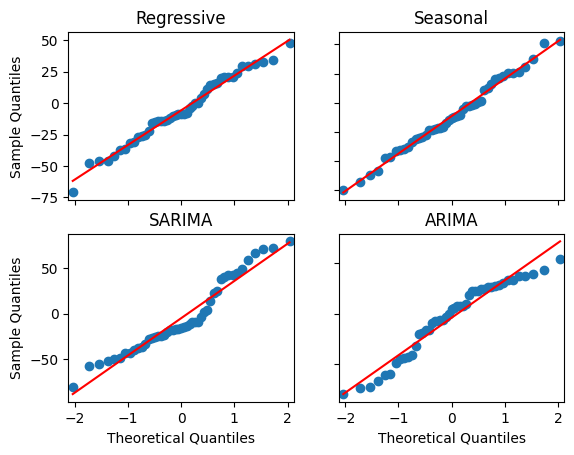

In [ ]:
print("Bhadla GHI Monthly Predictions")
main_function(file[1], param[2], type[3])

Bhadla GHI Weekly Predictions
                   GHI
datetime              
2001-01-07  443.973651
2001-01-14  465.649206
2001-01-21  494.443810
2001-01-28  530.479683
2001-02-04  567.247937
2001-02-11  572.084286
2001-02-18  510.722540
2001-02-25  517.227937
2001-03-04  654.971111
2001-03-11  655.967778
2001-03-18  685.272063
2001-03-25  636.271111
------------------------------
ADF Statistic : -10.556604133312076
p-value : 7.922669463190054e-19
The series is stationary
------------------------------


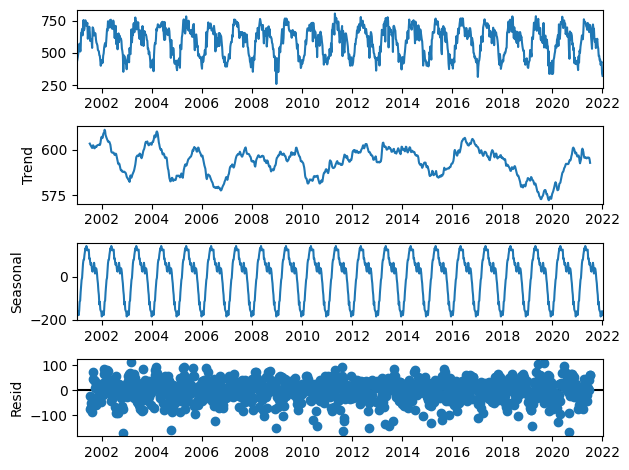

--------------REGRESSIVE DLM---------------
Tuning model...
Initializing models...
Initialization finished.
The algorithm stops without converging.
Possible reason: some discount is too close to 1 or 0.7 (0.7 is smallest discount that is permissible.
Tuning finished.
Tuned d: [0.99999, 0.99999, 0.99999]


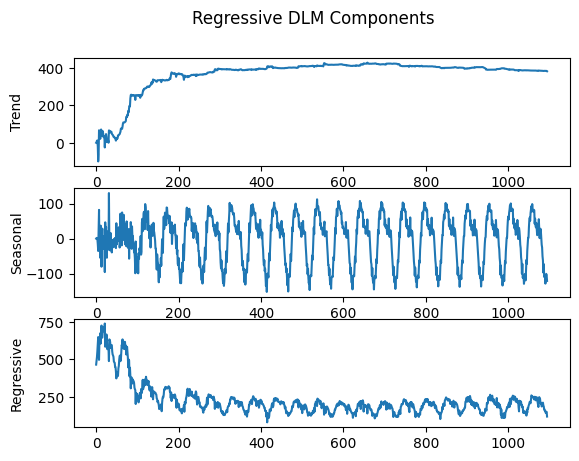

--------------SEASONAL DLM---------------
Tuning model...
Initializing models...
Initialization finished.
The algorithm stops without converging.
Possible reason: some discount is too close to 1 or 0.7 (0.7 is smallest discount that is permissible.
Tuning finished.
Tuned d: [0.99999, 0.99999]


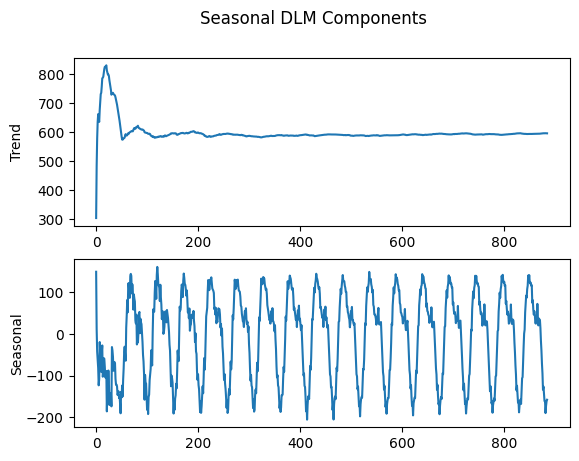

ARIMA Limits: (5, 3, 5)


100%|██████████| 5/5 [01:18<00:00, 15.73s/it]


------------------------------
Min Error = 61.09350289348098 ; Best Params = (1, 0, 0)
------------------------------
--------------SARIMA OVER---------------


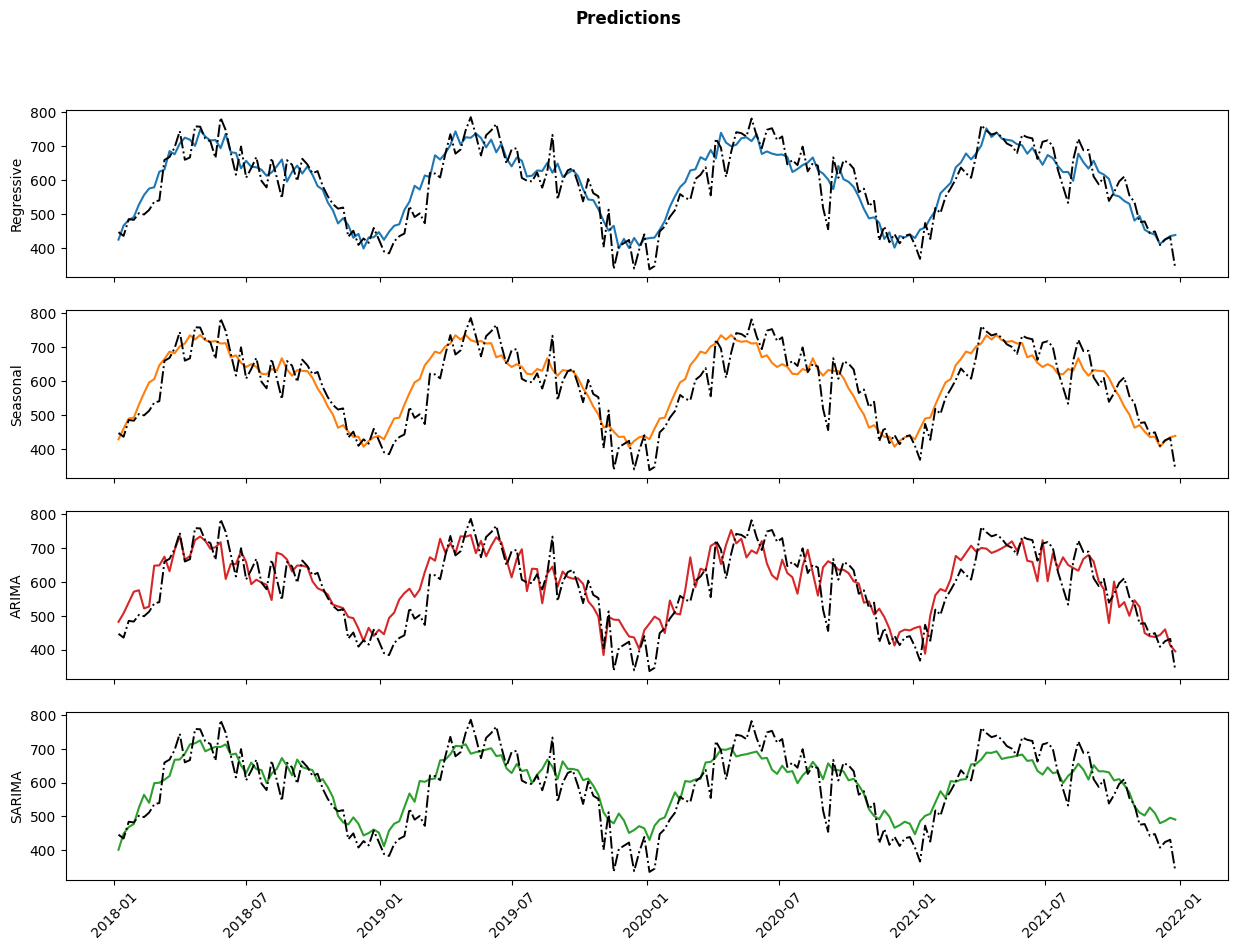

                0          1         2
Errors       RMSE        MAE      MAPE
Reg     48.496714  38.418341  0.066257
Seas    53.496339  42.926279   0.07347
SARIMA   56.39856  45.732815   0.07861
ARIMA   61.093503  47.826257  0.082126


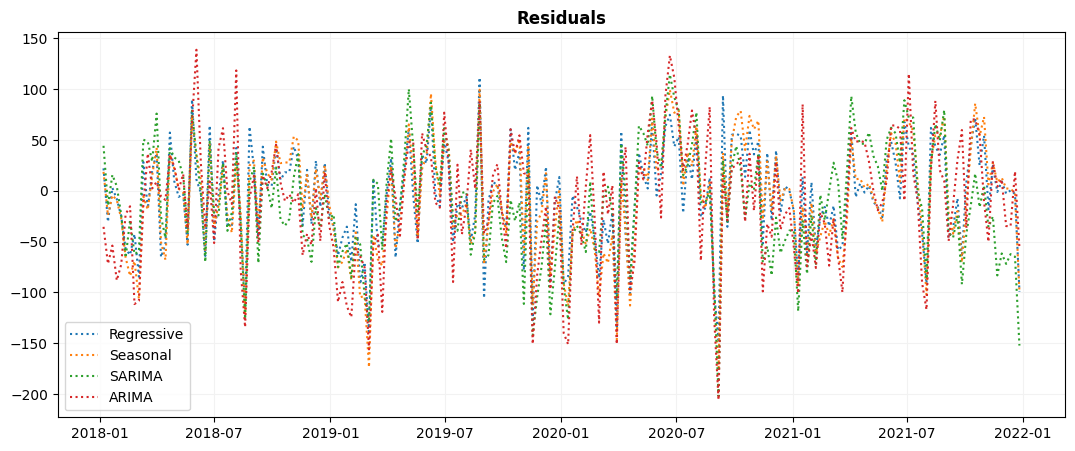

---------SHAPIRO WILK-----------
Regressive: ShapiroResult(statistic=0.9884846210479736, pvalue=0.0923701673746109)
Seasonal: ShapiroResult(statistic=0.9855150580406189, pvalue=0.03178245201706886)
     Fail to reject null hypothesis, residuals do not follow normal distribution
SARIMA: ShapiroResult(statistic=0.9920508861541748, pvalue=0.3185141384601593)
ARIMA: ShapiroResult(statistic=0.9910789132118225, pvalue=0.23031751811504364)
------------------------------


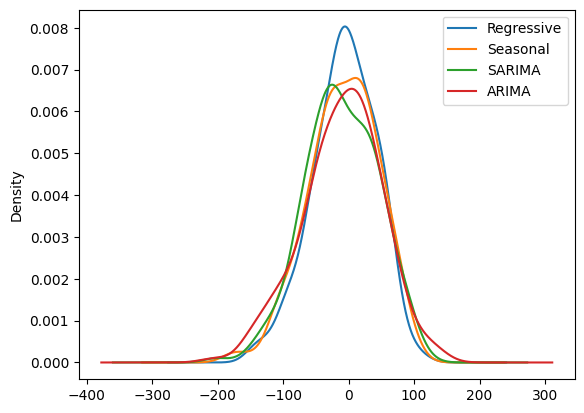

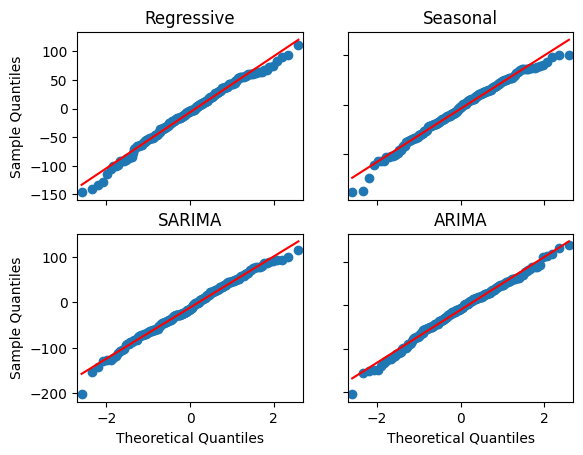

In [ ]:
print("Bhadla GHI Weekly Predictions")
main_function(file[1], param[2], type[2])

Tiru Wind Speed 50 Monthly Predictions
            Wind Speed 50
datetime                 
2011-01-31       4.778710
2011-02-28       3.632143
2011-03-31       3.596129
2011-04-30       3.997667
2011-05-31       6.276774
2011-06-30       7.290667
2011-07-31       6.812581
2011-08-31       6.918387
2011-09-30       6.567667
2011-10-31       4.556774
2011-11-30       4.880000
2011-12-31       4.933548
------------------------------
ADF Statistic : -1.7364350405091447
p-value : 0.41244451514704267
The series is NOT stationary
------------------------------


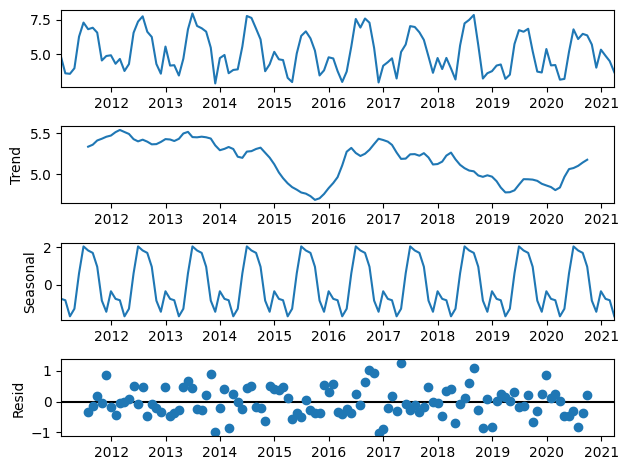

--------------REGRESSIVE DLM---------------
Tuning model...
Initializing models...
Initialization finished.
The algorithm stops without converging.
Possible reason: some discount is too close to 1 or 0.7 (0.7 is smallest discount that is permissible.
Tuning finished.
Tuned d: [0.99999, 0.99999, 0.99999]


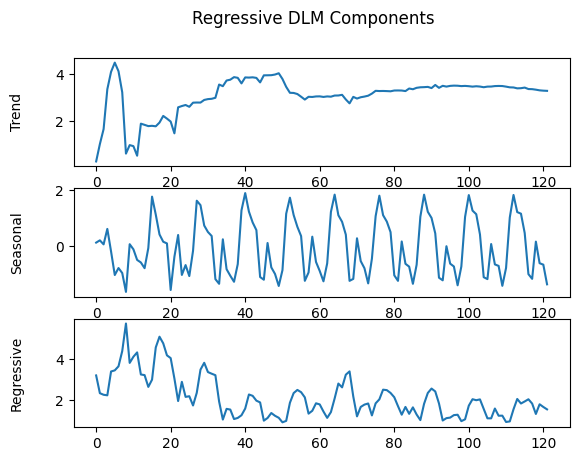

--------------SEASONAL DLM---------------
Tuning model...
Initializing models...
Initialization finished.
The algorithm stops without converging.
Possible reason: some discount is too close to 1 or 0.7 (0.7 is smallest discount that is permissible.
Tuning finished.
Tuned d: [0.99999, 0.99999]


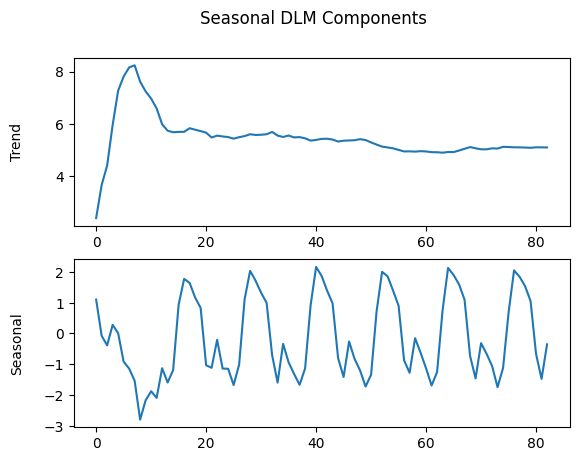

ARIMA Limits: (5, 3, 5)


100%|██████████| 5/5 [00:23<00:00,  4.66s/it]


------------------------------
Min Error = 1.2335148716919826 ; Best Params = (1, 0, 0)
------------------------------
--------------SARIMA OVER---------------


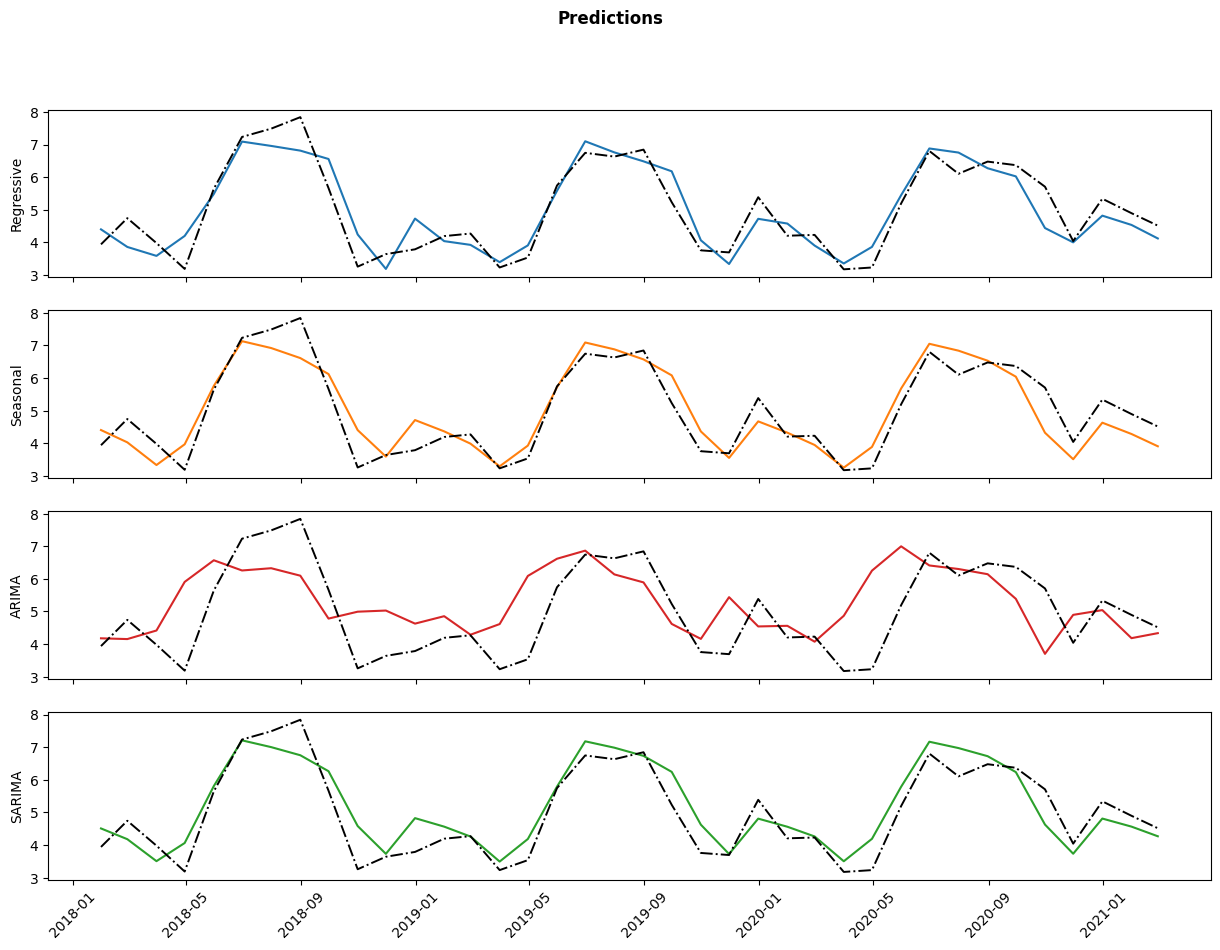

               0         1         2
Errors      RMSE       MAE      MAPE
Reg     0.563573  0.468831   0.09932
Seas    0.586193  0.477375  0.101547
SARIMA  0.596366  0.483826  0.098029
ARIMA   1.233515  0.981445  0.184877


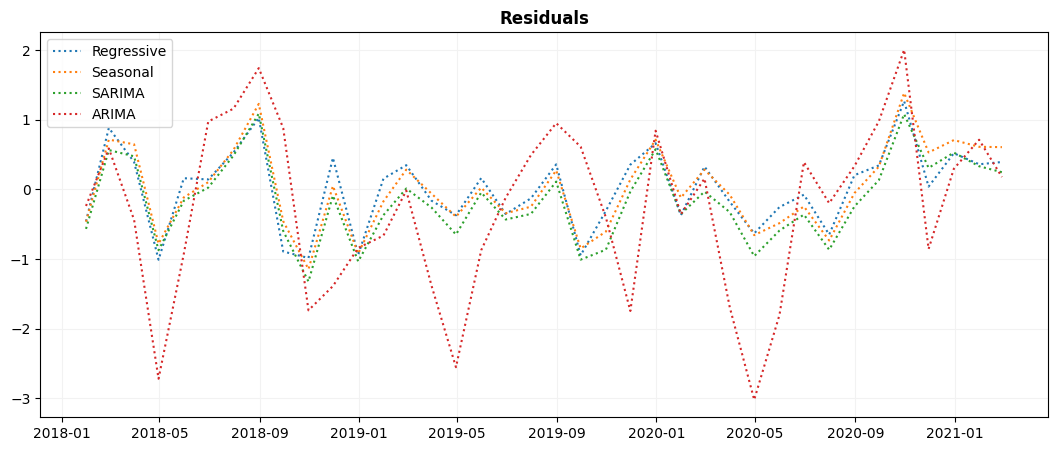

---------SHAPIRO WILK-----------
Regressive: ShapiroResult(statistic=0.9663564562797546, pvalue=0.3031248450279236)
Seasonal: ShapiroResult(statistic=0.9829967617988586, pvalue=0.8202238082885742)
SARIMA: ShapiroResult(statistic=0.9820147156715393, pvalue=0.7876884937286377)
ARIMA: ShapiroResult(statistic=0.971741259098053, pvalue=0.4405726194381714)
------------------------------


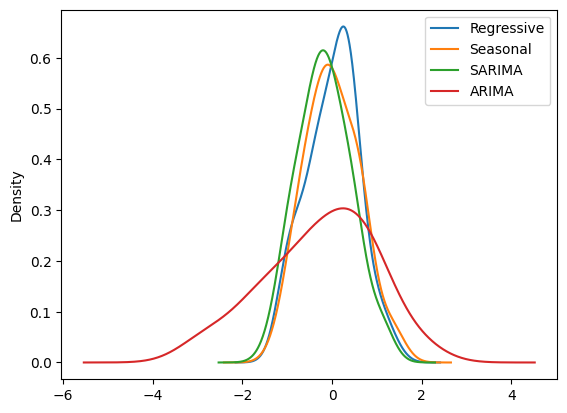

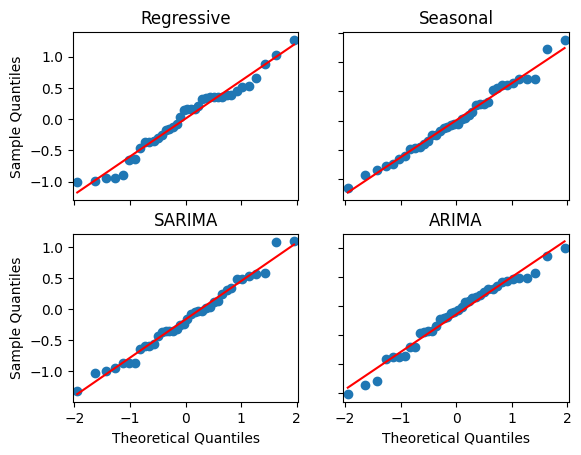

In [ ]:
print("Tiru Wind Speed 50 Monthly Predictions") # NOT Stationary
main_function(file[0], param[0], type[3])

Regressive Wind Speed 50 Weekly Predictions
            Wind Speed 50
datetime                 
2011-01-02       2.425000
2011-01-09       3.641429
2011-01-16       3.691429
2011-01-23       5.540000
2011-01-30       6.655714
2011-02-06       4.804286
2011-02-13       3.720000
2011-02-20       3.508571
2011-02-27       2.858571
2011-03-06       3.685714
2011-03-13       2.500000
2011-03-20       3.245714
------------------------------
ADF Statistic : -6.4586325869970445
p-value : 1.4619730460323056e-08
The series is stationary
------------------------------


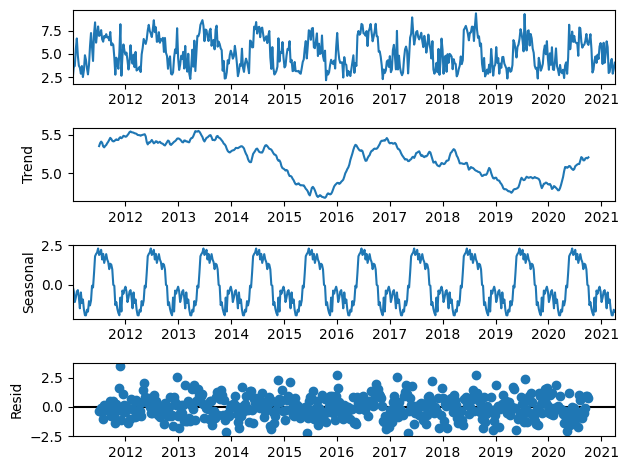

--------------REGRESSIVE DLM---------------
Tuning model...
Initializing models...
Initialization finished.
The algorithm stops without converging.
Possible reason: some discount is too close to 1 or 0.7 (0.7 is smallest discount that is permissible.
Tuning finished.
Tuned d: [0.99999, 0.99999, 0.99999]


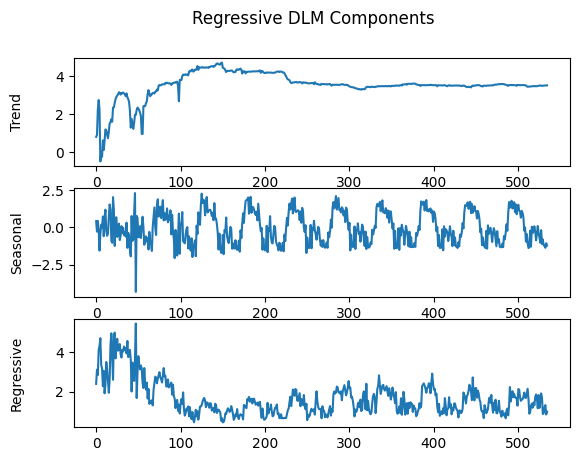

--------------SEASONAL DLM---------------
Tuning model...
Initializing models...
Initialization finished.
The algorithm stops without converging.
Possible reason: some discount is too close to 1 or 0.7 (0.7 is smallest discount that is permissible.
Tuning finished.
Tuned d: [0.99999, 0.99999]


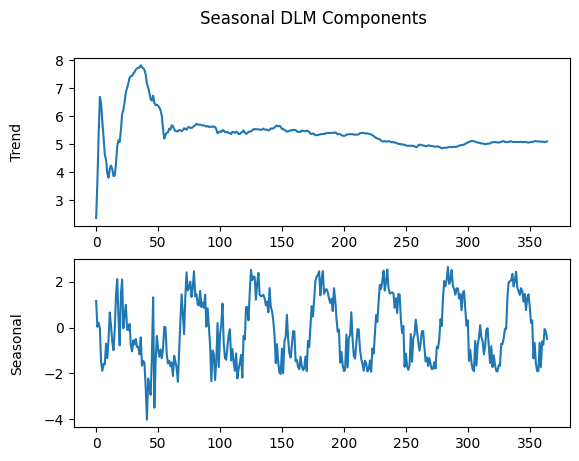

ARIMA Limits: (5, 3, 5)


100%|██████████| 5/5 [00:40<00:00,  8.09s/it]


------------------------------
Min Error = 1.2136932110042846 ; Best Params = (1, 0, 1)
------------------------------
--------------SARIMA OVER---------------


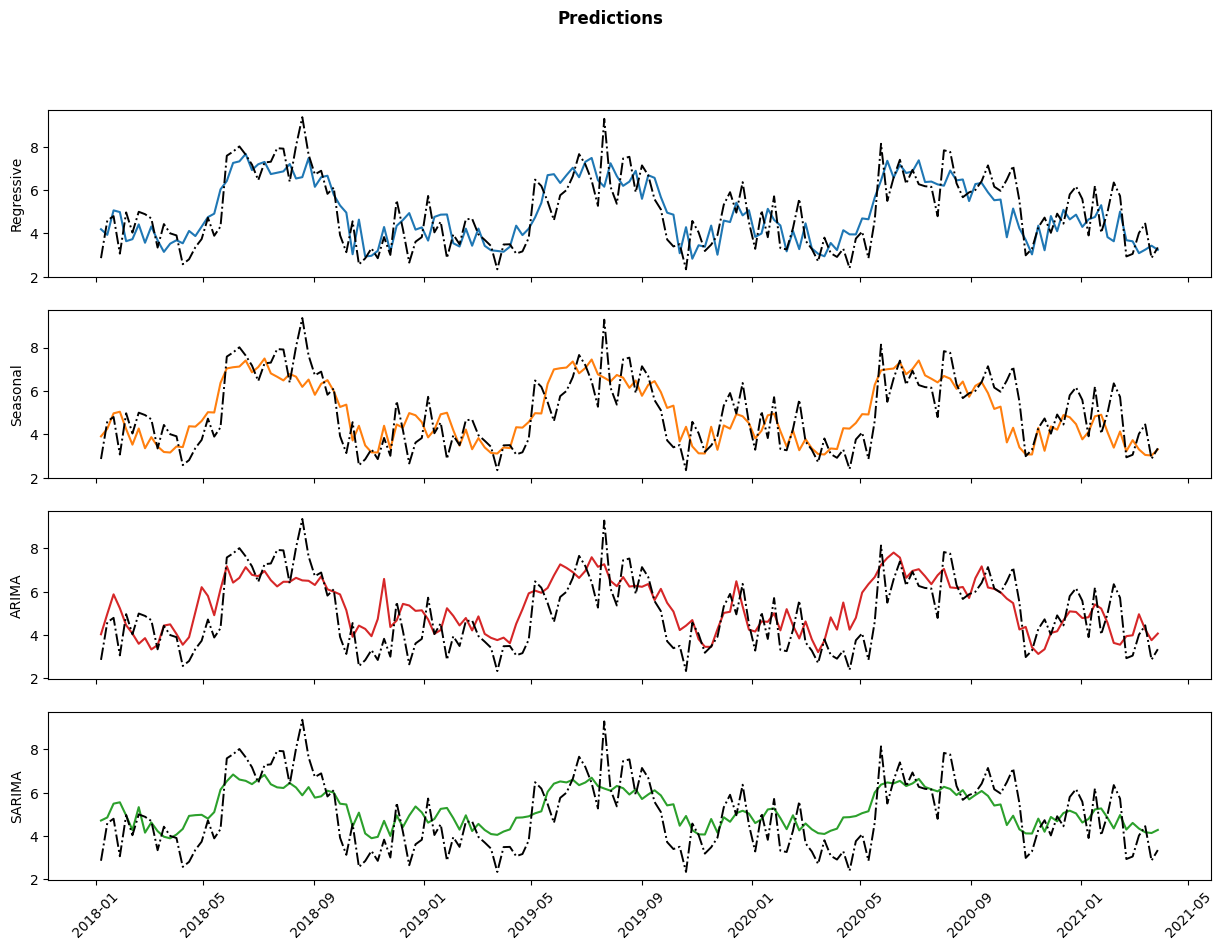

               0         1         2
Errors      RMSE       MAE      MAPE
Reg     1.083526  0.879489   0.18924
Seas    1.132684  0.903081  0.192652
SARIMA  1.198617  0.990458   0.19392
ARIMA   1.213693  0.982177  0.190857


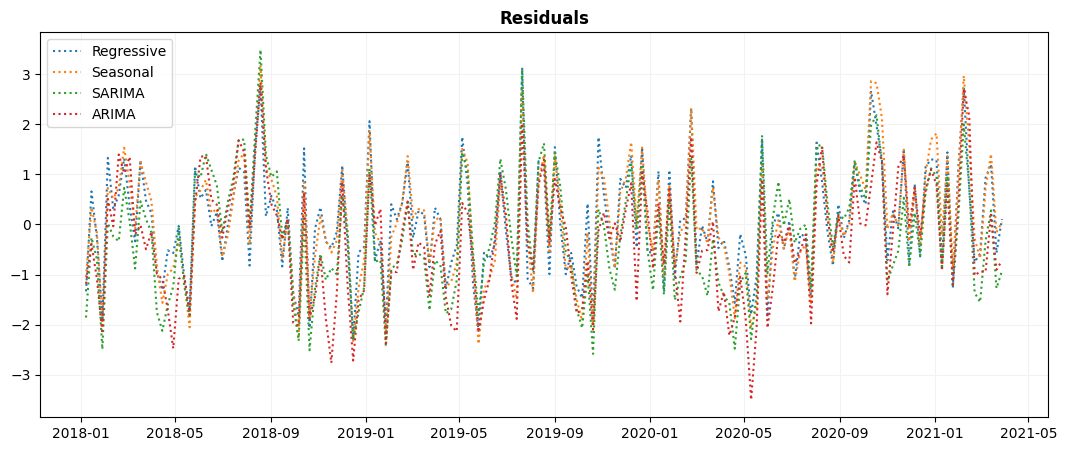

---------SHAPIRO WILK-----------
Regressive: ShapiroResult(statistic=0.9886342883110046, pvalue=0.1917324662208557)
Seasonal: ShapiroResult(statistic=0.9898090362548828, pvalue=0.2667570412158966)
SARIMA: ShapiroResult(statistic=0.9863359928131104, pvalue=0.09824167937040329)
ARIMA: ShapiroResult(statistic=0.9941279888153076, pvalue=0.7372665405273438)
------------------------------


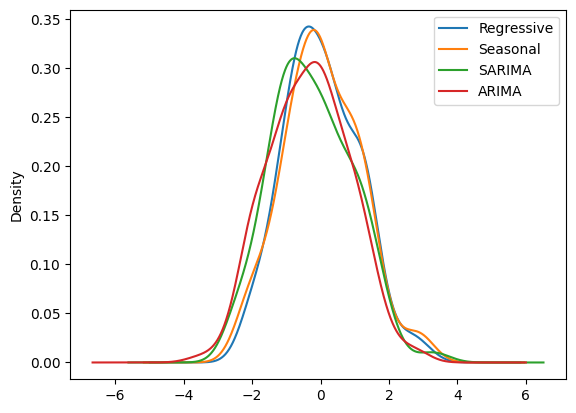

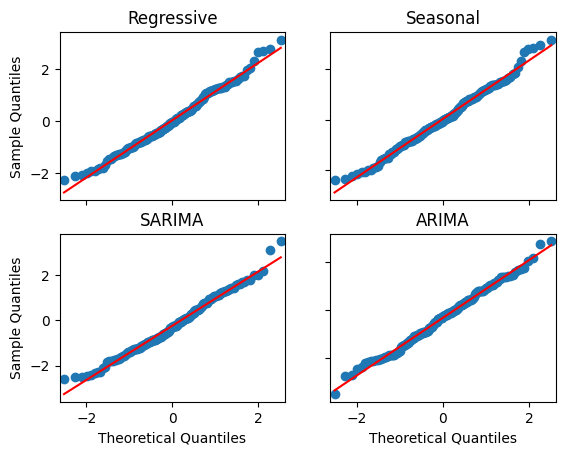

In [ ]:
print("Regressive Wind Speed 50 Weekly Predictions")
main_function(file[0], param[0], type[2])

Regressive Wind Speed Daily Predictions
            Wind Speed
datetime              
2015-08-01    7.128421
2015-08-02    7.293750
2015-08-03    6.264583
2015-08-04    5.925000
2015-08-05    5.449167
2015-08-06    5.570417
2015-08-07    6.697500
2015-08-08    6.467500
2015-08-09    8.137500
2015-08-10    7.248750
2015-08-11    7.414167
2015-08-12    7.502083
------------------------------
ADF Statistic : -4.12281187307635
p-value : 0.0008877683468229957
The series is stationary
------------------------------


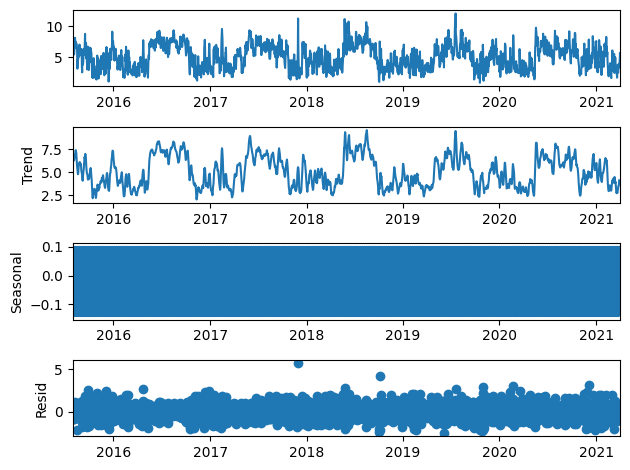

--------------REGRESSIVE DLM---------------


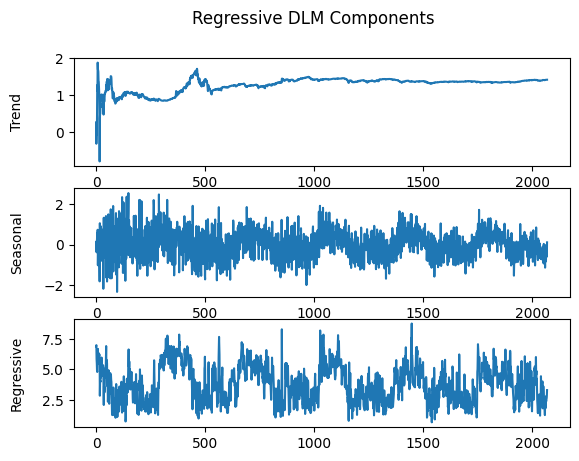

--------------SEASONAL DLM---------------


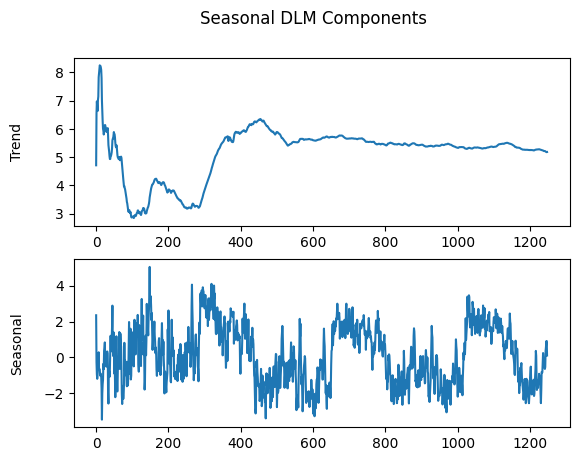

ARIMA Limits: (5, 3, 5)


100%|██████████| 5/5 [01:55<00:00, 23.06s/it]


------------------------------
Min Error = 2.190155890569566 ; Best Params = (0, 0, 1)
------------------------------
--------------SARIMA OVER---------------


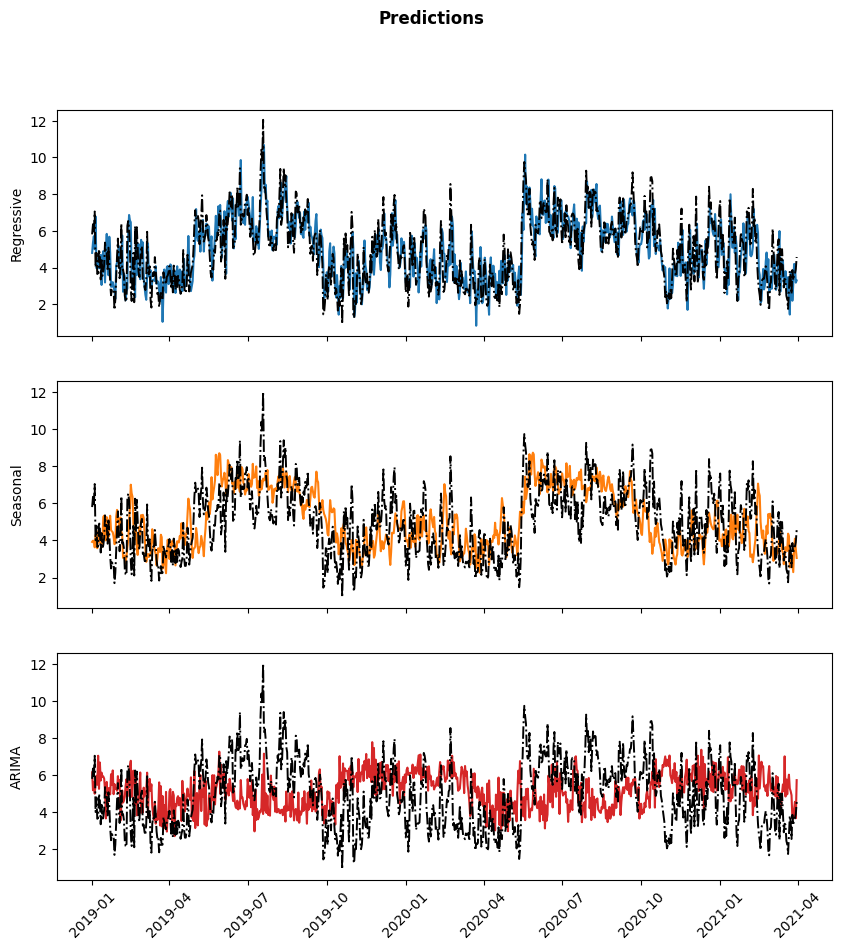

               0         1         2
Errors      RMSE       MAE      MAPE
Reg     1.171981  0.918647  0.210288
Seas    1.663436  1.338475  0.282432
SARIMA  2.190156  1.817134  0.363075
ARIMA   2.190156  1.817134  0.363075


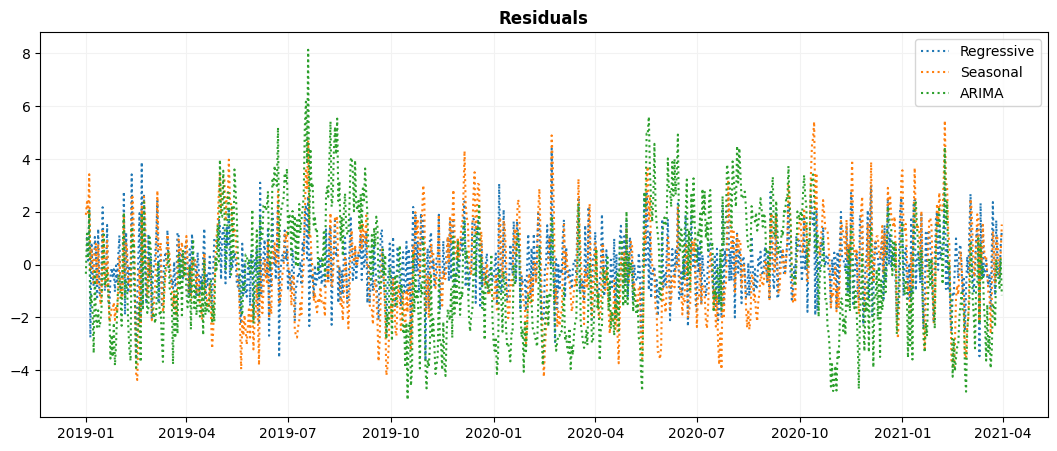

---------SHAPIRO WILK-----------
Regressive: ShapiroResult(statistic=0.9949421882629395, pvalue=0.00801143143326044)
     Fail to reject null hypothesis, residuals do not follow normal distribution
Seasonal: ShapiroResult(statistic=0.9940260052680969, pvalue=0.002421437529847026)
     Fail to reject null hypothesis, residuals do not follow normal distribution
ARIMA: ShapiroResult(statistic=0.9897782206535339, pvalue=1.7625219697947614e-05)
     Fail to reject null hypothesis, residuals do not follow normal distribution
------------------------------


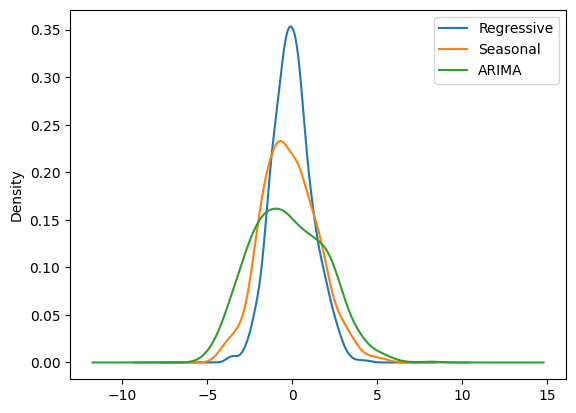

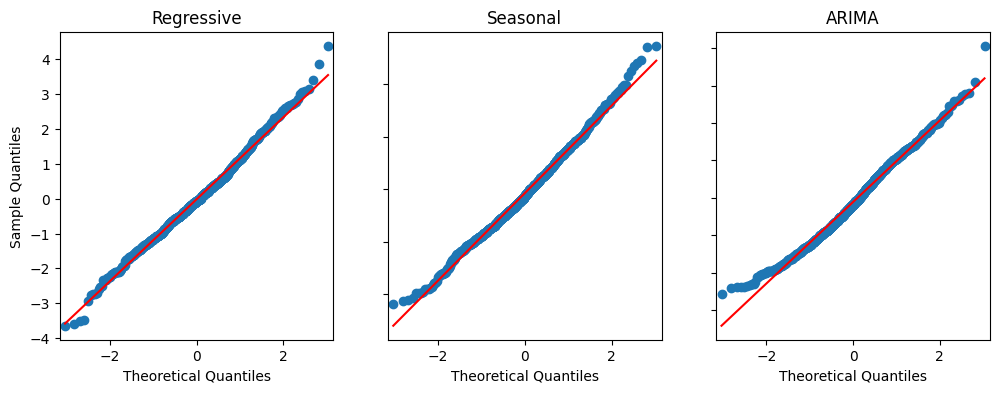

In [ ]:
print("Regressive Wind Speed Daily Predictions") # tiru_new less w
main_function(file[5], param[4], type[1])

Regressive Wind Speed Daily Predictions
            Wind Speed
datetime              
2015-08-01    6.536842
2015-08-02    7.023333
2015-08-03    6.552917
2015-08-04    7.427500
2015-08-05    7.312500
2015-08-06    6.614583
2015-08-07    6.703333
2015-08-08    4.785417
2015-08-09    3.629583
2015-08-10    4.730833
2015-08-11    3.346667
2015-08-12    2.832917
------------------------------
ADF Statistic : -4.891080493639421
p-value : 3.629566991469165e-05
The series is stationary
------------------------------


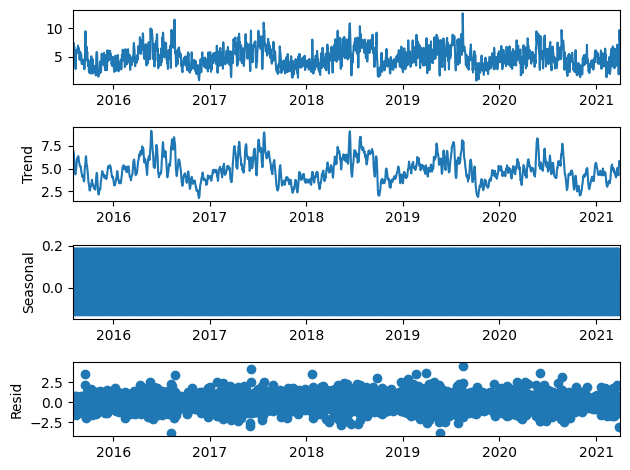

--------------REGRESSIVE DLM---------------


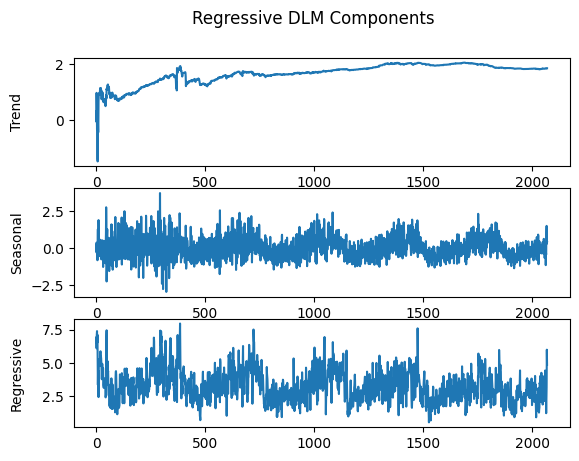

--------------SEASONAL DLM---------------
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.


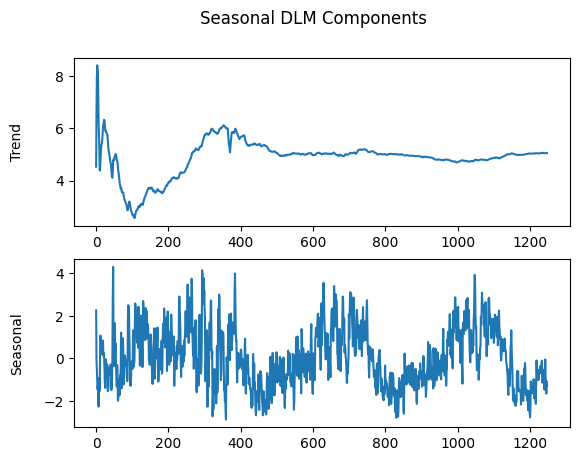

ARIMA Limits: (5, 3, 5)


100%|██████████| 5/5 [01:52<00:00, 22.57s/it]


------------------------------
Min Error = 1.8901479163659827 ; Best Params = (0, 0, 1)
------------------------------
--------------SARIMA OVER---------------


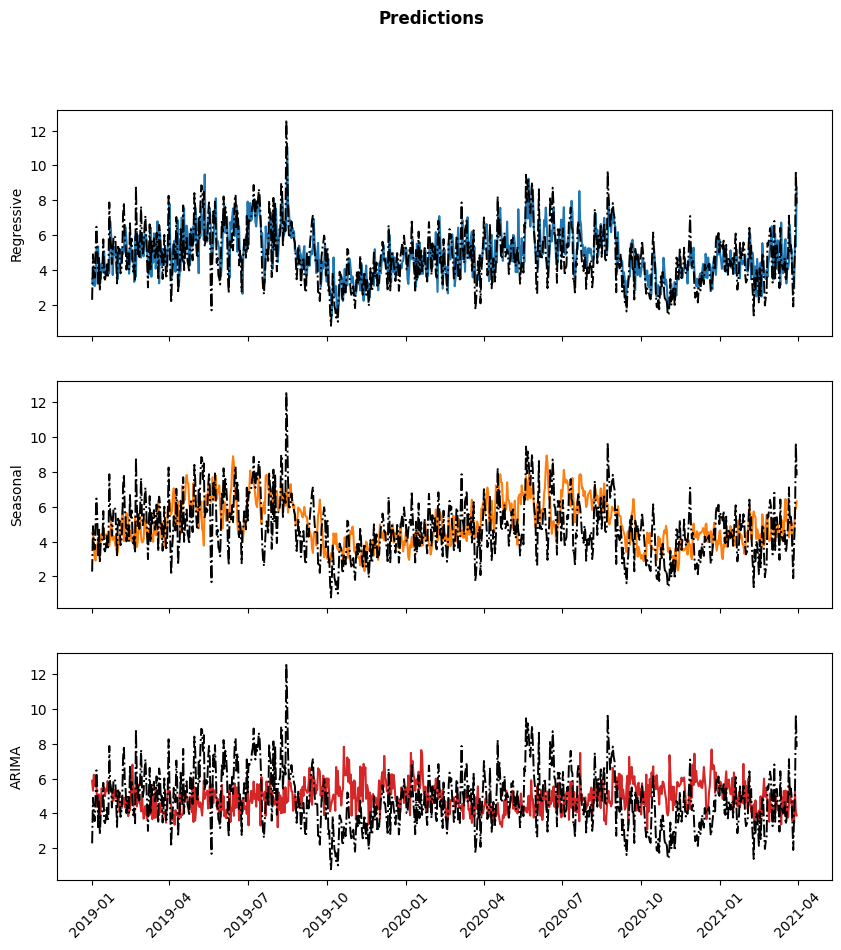

               0         1         2
Errors      RMSE       MAE      MAPE
Reg     1.308087   1.01798  0.219225
Seas    1.642417  1.320956  0.269477
SARIMA  1.890148  1.494645  0.305972
ARIMA   1.890148  1.494645  0.305972


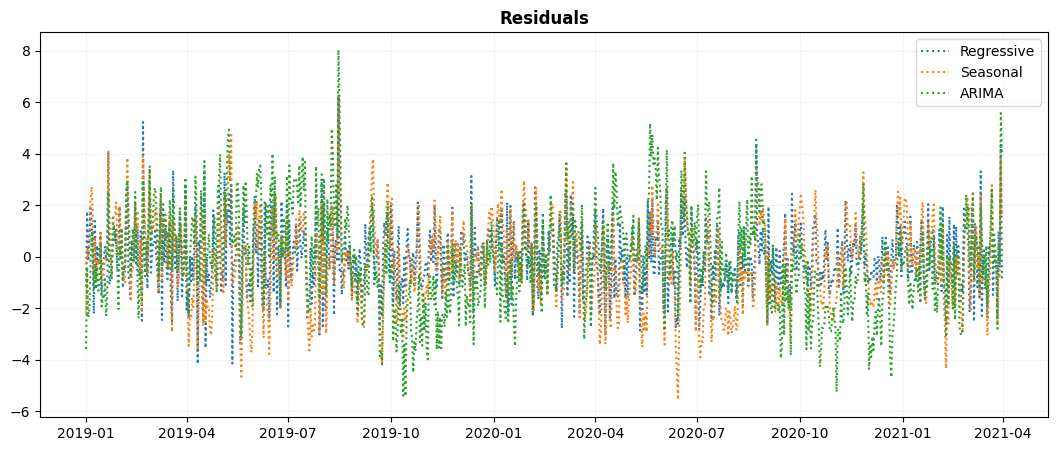

---------SHAPIRO WILK-----------
Regressive: ShapiroResult(statistic=0.991038978099823, pvalue=6.857501284684986e-05)
     Fail to reject null hypothesis, residuals do not follow normal distribution
Seasonal: ShapiroResult(statistic=0.9973483085632324, pvalue=0.2054586112499237)
ARIMA: ShapiroResult(statistic=0.9956298470497131, pvalue=0.020210525020956993)
     Fail to reject null hypothesis, residuals do not follow normal distribution
------------------------------


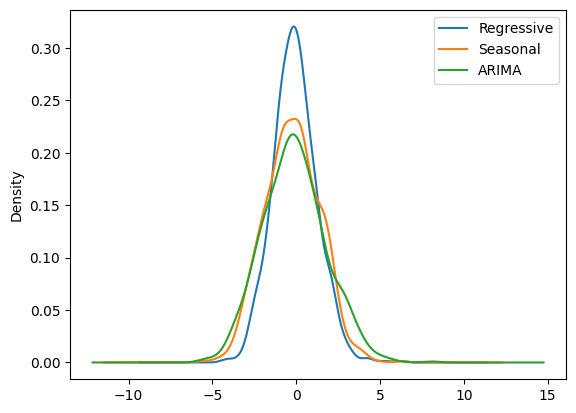

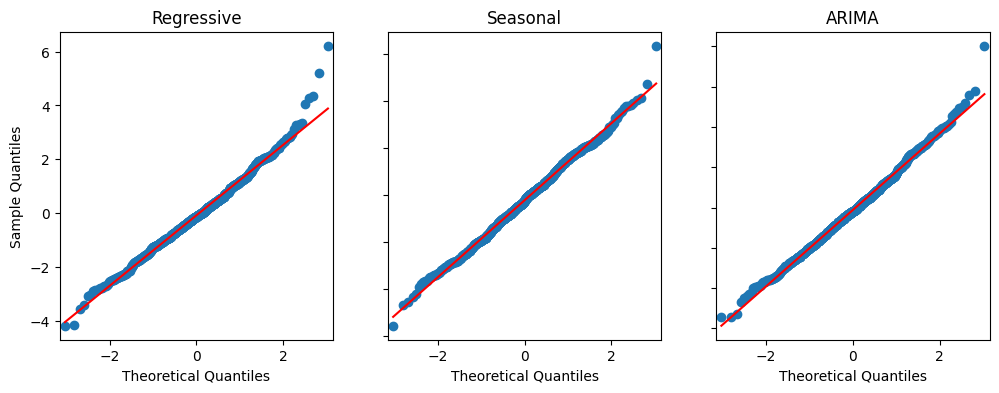

In [ ]:
print("Regressive Wind Speed Daily Predictions") # Bhopal
main_function(file[2], param[4], type[1])

Regressive Wind Speed Daily Predictions
            Wind Speed
datetime              
2015-08-01    5.445789
2015-08-02    4.400000
2015-08-03    2.564167
2015-08-04    3.097083
2015-08-05    3.764583
2015-08-06    3.347083
2015-08-07    3.616667
2015-08-08    3.794167
2015-08-09    2.693333
2015-08-10    2.450417
2015-08-11    3.755833
2015-08-12    3.131667
------------------------------
ADF Statistic : -5.367808654360927
p-value : 3.9564516009443154e-06
The series is stationary
------------------------------


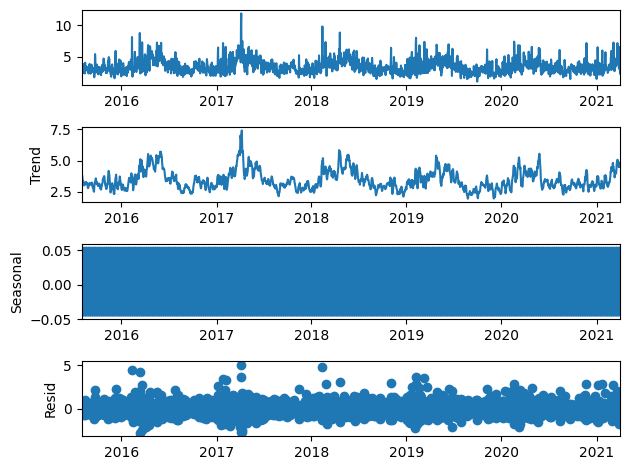

--------------REGRESSIVE DLM---------------


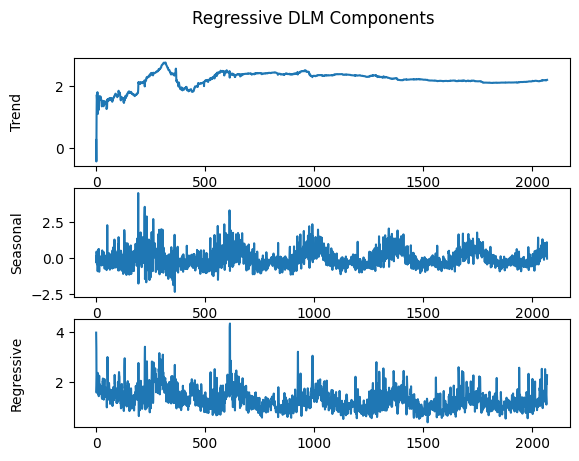

--------------SEASONAL DLM---------------
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.


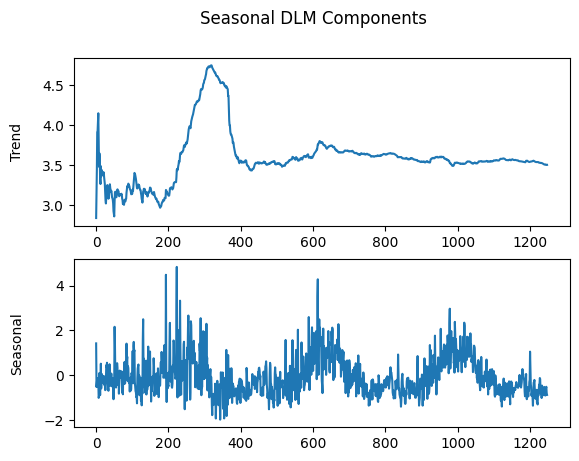

ARIMA Limits: (5, 3, 5)


100%|██████████| 5/5 [01:58<00:00, 23.74s/it]


------------------------------
Min Error = 1.251419478218782 ; Best Params = (0, 0, 1)
------------------------------
--------------SARIMA OVER---------------


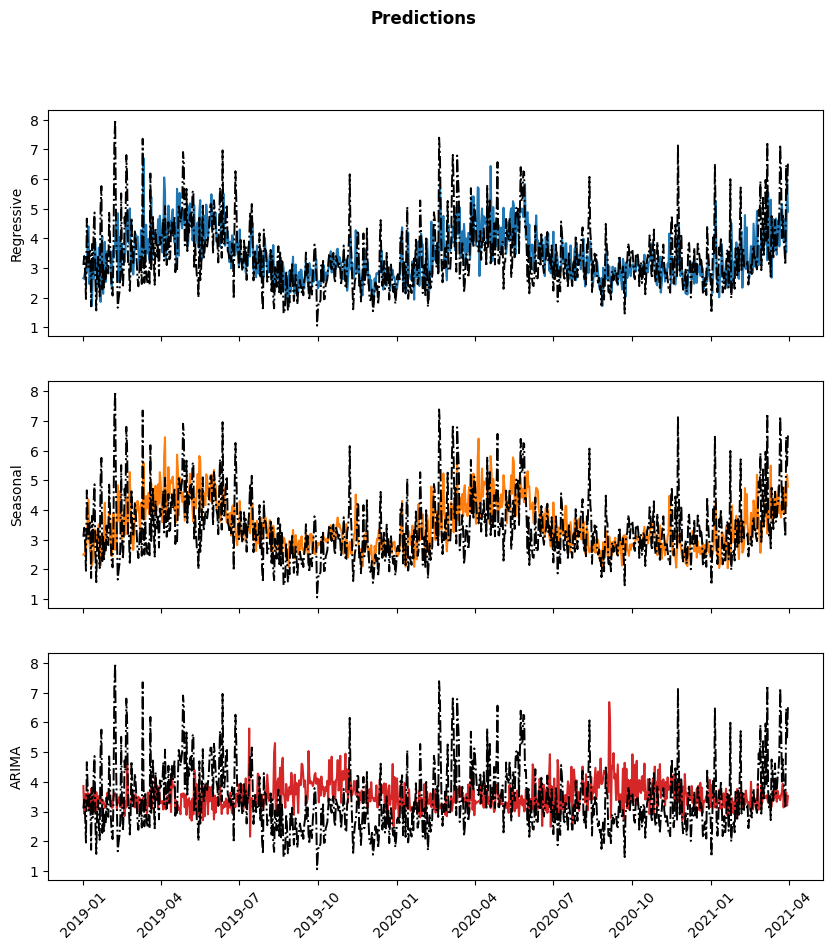

               0         1         2
Errors      RMSE       MAE      MAPE
Reg     1.035652  0.769325  0.224611
Seas    1.109414  0.831481  0.241036
SARIMA  1.251419   0.97209  0.273285
ARIMA   1.251419   0.97209  0.273285


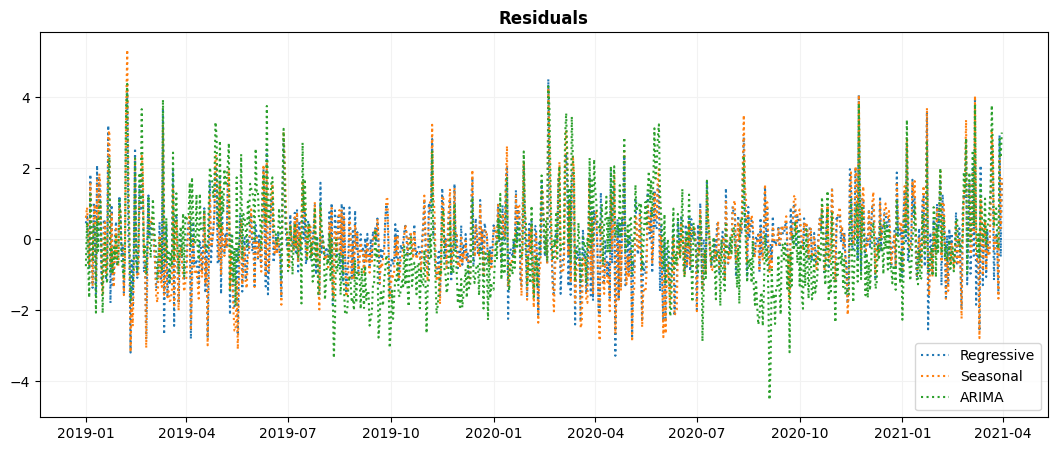

---------SHAPIRO WILK-----------
Regressive: ShapiroResult(statistic=0.9732975363731384, pvalue=4.1464696259874145e-11)
     Fail to reject null hypothesis, residuals do not follow normal distribution
Seasonal: ShapiroResult(statistic=0.9732063412666321, pvalue=3.922078981033472e-11)
     Fail to reject null hypothesis, residuals do not follow normal distribution
ARIMA: ShapiroResult(statistic=0.9712017178535461, pvalue=1.1883463831019458e-11)
     Fail to reject null hypothesis, residuals do not follow normal distribution
------------------------------


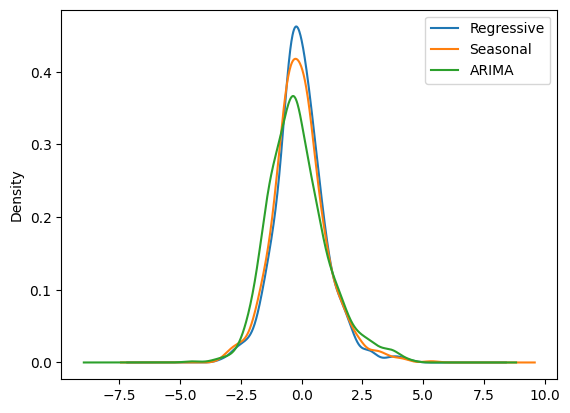

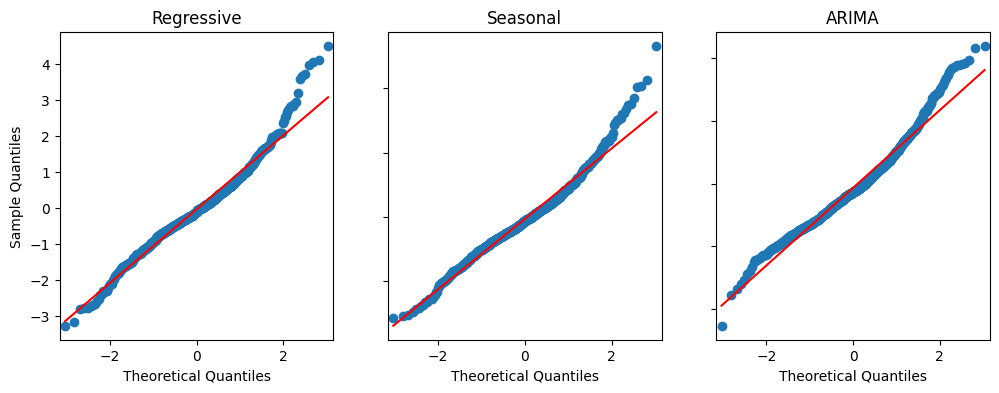

In [ ]:
print("Regressive Wind Speed Daily Predictions") # Hamirpur
main_function(file[3], param[4], type[1])

Regressive Wind Speed Daily Predictions
            Wind Speed
datetime              
2015-08-01   10.333158
2015-08-02    9.118750
2015-08-03    8.108333
2015-08-04    8.332083
2015-08-05    9.051667
2015-08-06    8.514167
2015-08-07    7.189167
2015-08-08    6.422083
2015-08-09    5.437917
2015-08-10    5.352917
2015-08-11    4.362083
2015-08-12    4.697917
------------------------------
ADF Statistic : -5.925183654076523
p-value : 2.453240516536808e-07
The series is stationary
------------------------------


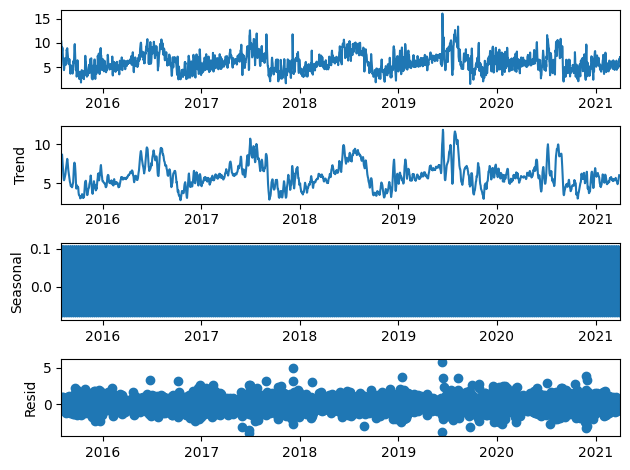

--------------REGRESSIVE DLM---------------


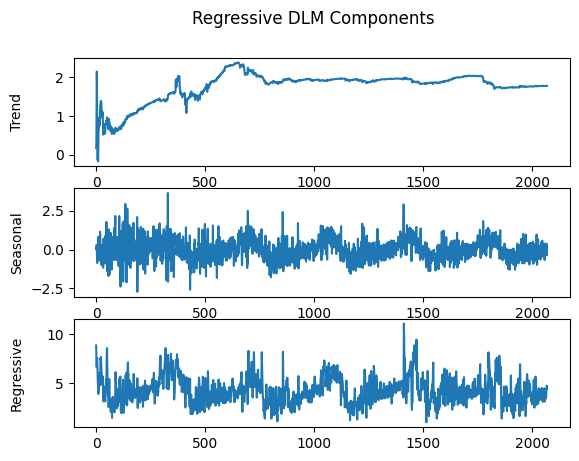

--------------SEASONAL DLM---------------
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.


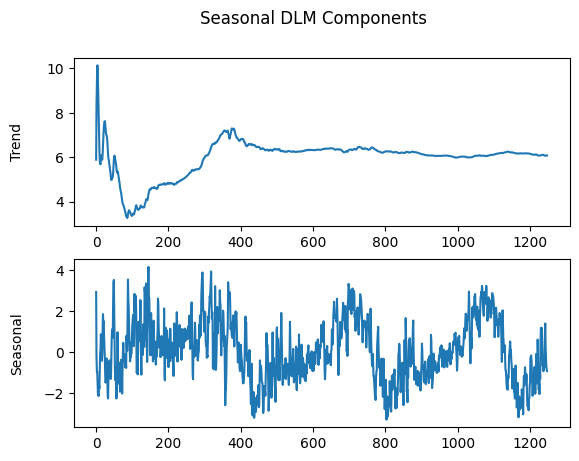

ARIMA Limits: (5, 3, 5)


100%|██████████| 5/5 [01:56<00:00, 23.23s/it]


------------------------------
Min Error = 2.157489085761818 ; Best Params = (0, 0, 1)
------------------------------
--------------SARIMA OVER---------------


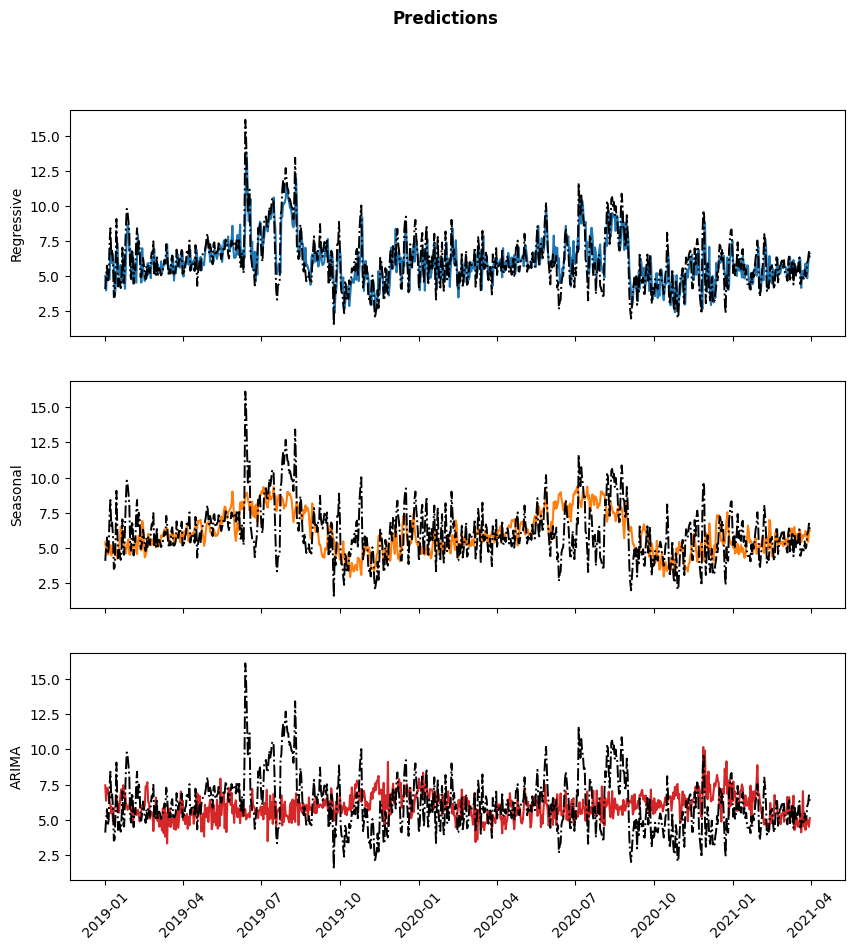

               0         1         2
Errors      RMSE       MAE      MAPE
Reg      1.26776  0.960085   0.16789
Seas    1.826825  1.380828  0.236203
SARIMA  2.157489  1.635235  0.278569
ARIMA   2.157489  1.635235  0.278569


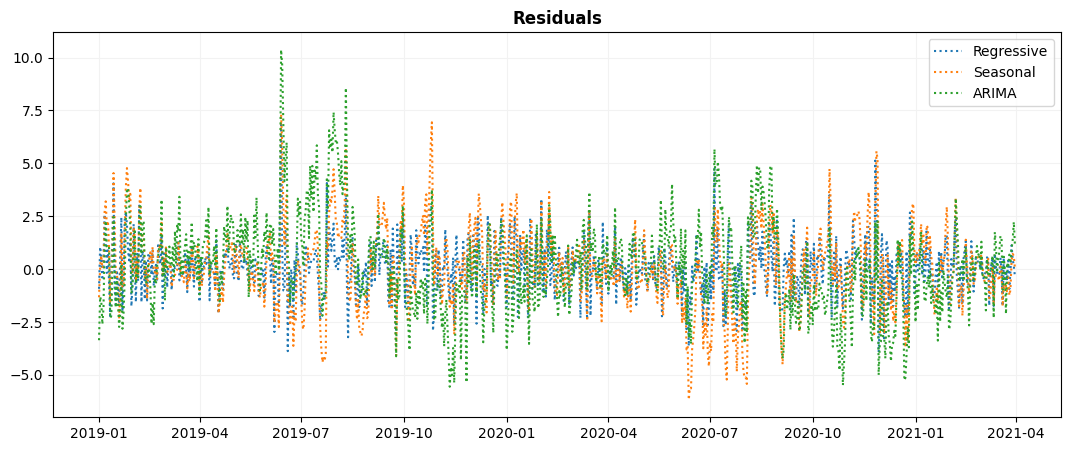

---------SHAPIRO WILK-----------
Regressive: ShapiroResult(statistic=0.9863686561584473, pvalue=6.374371537276602e-07)
     Fail to reject null hypothesis, residuals do not follow normal distribution
Seasonal: ShapiroResult(statistic=0.9889271855354309, pvalue=7.353895853157155e-06)
     Fail to reject null hypothesis, residuals do not follow normal distribution
ARIMA: ShapiroResult(statistic=0.9813697338104248, pvalue=1.0057979338284895e-08)
     Fail to reject null hypothesis, residuals do not follow normal distribution
------------------------------


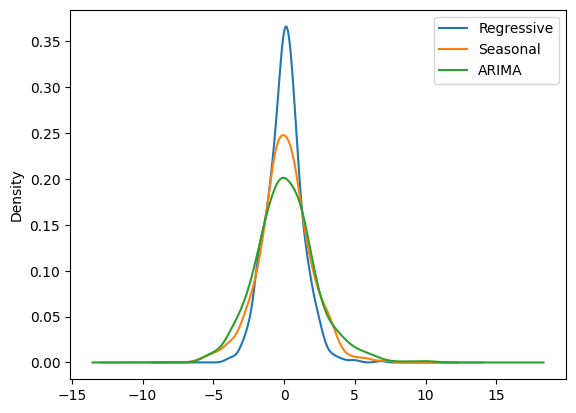

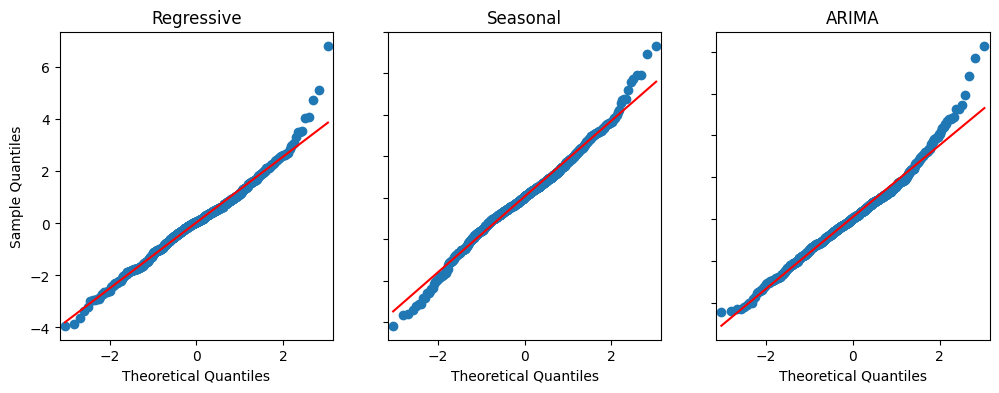

In [ ]:
print("Regressive Wind Speed Daily Predictions") # Jafrabad
main_function(file[4], param[4], type[1])